In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.special
from sklearn.linear_model import LassoCV, LinearRegression, ElasticNetCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.base import clone
import joblib
from statsmodels.api import OLS
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

In [41]:
from myflaml import auto_reg, auto_clf, auto_weighted_reg

# Setting the High Level Parameters for the Notebook

In [48]:
time_budget = 120 # time budget for auto-ml in seconds (advisable around 120)
verbose = 3 # verbosity of auto-ml
n_splits = 5 # cross-fitting and cross-validation splits
data = '401k' # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'star'}
plot = True # whether to plot results
xfeat = 'inc' # feature to use as x axis in plotting, e.g. for criteo 'f1', for 401k 'inc', for welfare 'polviews'
# Formula for the BLP of CATE regression.
blp_formula = 'np.log(inc)' # e.g. 'f1' for criteo, np.log(inc)' for 401k, 'C(polviews)' for the welfare case.
binary_y = False

## For semi-synthetic data generation; available only if data='401k' 
semi_synth = False # True is available only if data='401k'
simple_synth = True # True is available only if data='401k'
max_depth = 2 # max depth of random forest during for semi-synthetic model fitting
scale = .2 # magnitude of noise in semi-synthetic data
def simple_true_cef(D, X): # simple CEF of the outcome for semi-synthetic data
    return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]

# Fetching the Data

The Criteo dataset can be downloaded from here:
https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/input
This file should be downloaded and stored in the same folder as the notebook with the name `criteo-uplift-v2.1.csv`.

The welfare dataset can be downloaded from here:
https://github.com/gsbDBI/ExperimentData/blob/master/Welfare/ProcessedData/welfarenolabel3.csv
This file should be downloaded and stored in the same folder as the notebook with the name `welfarenolabel3.csv`. And is drawn from the analysis in this paper: [Green and Kern, 2012, Modeling Heterogeneous Treatment Effects in Survey Experiments with Bayesian Additive Regression Trees](https://github.com/gsbDBI/ExperimentData/blob/master/Welfare/Green%20and%20Kern%20BART.pdf)

The 401k dataset is downloaded from the source by the code and no need to further download anything:
https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.csv

In [49]:
from datasets import fetch_data_generator

get_data, abtest, true_cef, true_cate = fetch_data_generator(data=data, semi_synth=semi_synth, simple_synth=simple_synth,
                                                             scale=scale, true_f=simple_true_cef, max_depth=max_depth)
X, D, y, groups = get_data()

In [50]:
if semi_synth:
    true_ate = np.mean(true_cate(X))
    print(f'True ATE: {true_ate}')

In [51]:
def rmse(cate, preds):
    return np.sqrt(np.mean((cate - preds)**2))

# Data Analysis

We now have our data $X$, $D$, $y$, of controls, treatments and outcomes. In some datasets, we also have "groups", also known as "clusters". These are group ids, that define a group of samples that are believed to be correlated through unobesrved factors. For instance, in randomized experiments when a whole class is being treated and we have data at the student level, the students in a class constitute a cluster, as their outcome variables are most probably correlated. In such settings, it is helpful to account for the cluster correlations when calculating confidence intervals and when performing sample splitting for either cross-validation or for nuisance estimation.

We will be assuming throughout that conditional ignorability is satisfied if we control for all the variables $X$, i.e. the potential outcomes $Y(1), Y(0)$ satisfy
\begin{align}
Y(1), Y(0) ~\perp\hspace{-1em}\perp~D \mid X
\end{align}
Equivalently, we assume that the DAG the corresponds to our setting satisfies that $X$ is a valid adjustment set between $D$ and $Y$, i.e. it blocks all backdoor paths in the DAG.

In [52]:
X.describe()

,age,inc,fsize,educ,db,marr,male,twoearn,pira,nohs,hs,smcol,col,hown
count,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000,9716.000000
mean,41.034891,36462.224269,2.868361,13.192672,0.271202,0.603746,0.205949,0.380198,0.238678,0.127419,0.379477,0.247118,0.245986,0.635241
std,10.337014,22193.821846,1.541154,2.787505,0.444603,0.489143,0.404414,0.485460,0.426298,0.333459,0.485282,0.431358,0.430692,0.481387
min,25.000000,4080.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,19648.500000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,31473.000000,3.000000,12.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,48.000000,48071.250000,4.000000,15.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,64.000000,118599.000000,13.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


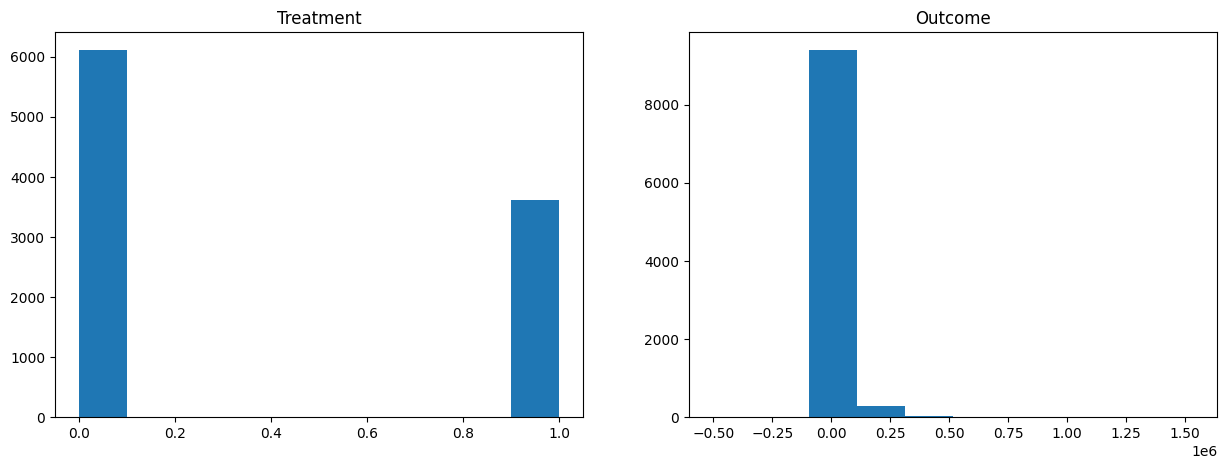

In [53]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(D)
plt.title('Treatment')
plt.subplot(1, 2, 2)
plt.hist(y)
plt.title('Outcome')
plt.show()

# Split Train and Validation and Test

The training data will be used to fit the various CATE models. The validation data will be used for scoring and selection of the best CATE model or best ensemble of CATE models. The test data will be used for testing and evaluation of the performance of the best chosen model. 

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

if groups is None:
    X, Xval, D, Dval, y, yval = train_test_split(X, D, y, train_size=.6, shuffle=True, random_state=123)
    Xval, Xtest, Dval, Dtest, yval, ytest = train_test_split(Xval, Dval, yval, train_size=.5, shuffle=True, random_state=123)
    groupsval, groupstest = None, None
else:
    train, val = next(GroupShuffleSplit(n_splits=2, train_size=.6, random_state=123).split(X, y, groups=groups))
    X, Xval, D, Dval, y, yval = X.iloc[train], X.iloc[val], D[train], D[val], y[train], y[val]
    groups, groupsval = groups[train], groups[val]

    val, test = next(GroupShuffleSplit(n_splits=2, train_size=.5, random_state=123).split(Xval, yval, groups=groupsval))
    Xval, Xtest, Dval, Dtest, yval, ytest = Xval.iloc[val], Xval.iloc[test], Dval[val], Dval[test], yval[val], yval[test]
    groupsval, groupstest = groupsval[val], groupsval[test]

# Nuisance Model Selection

Using the training data we will select the best model for each of the nuisance models that arise in meta learner CATE approaches. They five models correspond to the following five predictive problems:
\begin{align}
\text{model_reg} ~\rightarrow~& g(d, x) := E[Y\mid D=d, X=x]\\
\text{model_y} ~\rightarrow~& q(x) := E[Y\mid X=x]\\
\text{model_t} ~\rightarrow~& p(x) := E[D\mid X=x] = \Pr(D=1\mid X=x)\\
\text{model_reg_zero} ~\rightarrow~& g_0(x) := E[Y\mid D=0, X=x]\\
\text{model_reg_one} ~\rightarrow~& g_1(x) := E[Y\mid D=1, X=x]\\
\end{align}
We will select the best hyperparameters/model type for each predictive problem using cross-validation, where the splits are also stratified by the treatment (so that we have balanced split of the treatment groups across folds).

In [11]:
if groups is None:
    split_type = 'auto'
else:
    split_type = GroupKFold(n_splits=n_splits)

In [12]:

# These function calls perform auto-ml hyperparameter tuning and return a "model class generator"
# i.e. a function that whenever called returns an instance of an un-fitted model with the best hyper-parameters
if binary_y:
    model_reg = auto_clf(np.column_stack((D, X)), y, groups=groups, n_splits=n_splits, split_type=split_type, 
                         verbose=verbose, time_budget=time_budget)
    model_y = auto_clf(X, y, n_splits=n_splits, split_type=split_type, 
                       verbose=verbose, time_budget=time_budget)
    model_reg_zero = auto_clf(X[D==0], y[D==0], groups=groups, n_splits=n_splits, split_type=split_type, 
                              verbose=verbose, time_budget=time_budget)
    model_reg_one = auto_clf(X[D==1], y[D==1], groups=groups, n_splits=n_splits, split_type=split_type, 
                             verbose=verbose, time_budget=time_budget)
else:
    model_reg = auto_reg(np.column_stack((D, X)), y, groups=groups, n_splits=n_splits, split_type=split_type, 
                         verbose=verbose, time_budget=time_budget)
    model_y = auto_reg(X, y, groups=groups, n_splits=n_splits, split_type=split_type, 
                       verbose=verbose, time_budget=time_budget)
    model_reg_zero = auto_reg(X[D==0], y[D==0], groups=groups, n_splits=n_splits, split_type=split_type, 
                              verbose=verbose, time_budget=time_budget)
    model_reg_one = auto_reg(X[D==1], y[D==1], groups=groups, n_splits=n_splits, split_type=split_type, 
                             verbose=verbose, time_budget=time_budget)
model_t = auto_clf(X, D, groups=groups, n_splits=n_splits, split_type=split_type, 
                   verbose=verbose, time_budget=time_budget)

[flaml.automl.automl: 03-12 23:21:03] {2715} INFO - task = regression
[flaml.automl.automl: 03-12 23:21:03] {2717} INFO - Data split method: uniform
[flaml.automl.automl: 03-12 23:21:03] {2720} INFO - Evaluation method: cv
[flaml.automl.automl: 03-12 23:21:03] {2847} INFO - Minimizing error metric: mse
[flaml.automl.automl: 03-12 23:21:03] {2993} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.automl: 03-12 23:21:03] {3322} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 03-12 23:21:04] {3460} INFO - Estimated sufficient time budget=390s. Estimated necessary time budget=3s.
[flaml.automl.automl: 03-12 23:21:04] {3507} INFO -  at 0.0s,	estimator lgbm's best error=2788058717.4976,	best estimator lgbm's best error=2788058717.4976
[flaml.automl.automl: 03-12 23:21:04] {3322} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 03-12 23:21:04] {3507} INFO -  at 0.1s,	estimator lgbm's best error=278805

[flaml.automl.automl: 03-12 23:21:09] {3507} INFO -  at 5.3s,	estimator lgbm's best error=2451548906.8907,	best estimator lgbm's best error=2451548906.8907
[flaml.automl.automl: 03-12 23:21:09] {3322} INFO - iteration 32, current learner lgbm
[flaml.automl.automl: 03-12 23:21:09] {3507} INFO -  at 5.5s,	estimator lgbm's best error=2451548906.8907,	best estimator lgbm's best error=2451548906.8907
[flaml.automl.automl: 03-12 23:21:09] {3322} INFO - iteration 33, current learner extra_tree
[flaml.automl.automl: 03-12 23:21:09] {3507} INFO -  at 5.9s,	estimator extra_tree's best error=2558833073.6263,	best estimator lgbm's best error=2451548906.8907
[flaml.automl.automl: 03-12 23:21:09] {3322} INFO - iteration 34, current learner lgbm
[flaml.automl.automl: 03-12 23:21:10] {3507} INFO -  at 6.1s,	estimator lgbm's best error=2451548906.8907,	best estimator lgbm's best error=2451548906.8907
[flaml.automl.automl: 03-12 23:21:10] {3322} INFO - iteration 35, current learner xgboost
[flaml.automl

[flaml.automl.automl: 03-12 23:21:18] {3507} INFO -  at 14.2s,	estimator xgb_limitdepth's best error=2462364581.1760,	best estimator lgbm's best error=2428757887.4828
[flaml.automl.automl: 03-12 23:21:18] {3322} INFO - iteration 65, current learner lgbm
[flaml.automl.automl: 03-12 23:21:18] {3507} INFO -  at 14.3s,	estimator lgbm's best error=2428757887.4828,	best estimator lgbm's best error=2428757887.4828
[flaml.automl.automl: 03-12 23:21:18] {3322} INFO - iteration 66, current learner xgb_limitdepth
[flaml.automl.automl: 03-12 23:21:18] {3507} INFO -  at 14.5s,	estimator xgb_limitdepth's best error=2462364581.1760,	best estimator lgbm's best error=2428757887.4828
[flaml.automl.automl: 03-12 23:21:18] {3322} INFO - iteration 67, current learner xgb_limitdepth
[flaml.automl.automl: 03-12 23:21:18] {3507} INFO -  at 14.9s,	estimator xgb_limitdepth's best error=2462364581.1760,	best estimator lgbm's best error=2428757887.4828
[flaml.automl.automl: 03-12 23:21:18] {3322} INFO - iteration

[flaml.automl.automl: 03-12 23:21:31] {3322} INFO - iteration 96, current learner xgb_limitdepth
[flaml.automl.automl: 03-12 23:21:31] {3507} INFO -  at 27.6s,	estimator xgb_limitdepth's best error=2396526751.8044,	best estimator xgb_limitdepth's best error=2396526751.8044
[flaml.automl.automl: 03-12 23:21:31] {3322} INFO - iteration 97, current learner extra_tree
[flaml.automl.automl: 03-12 23:21:32] {3507} INFO -  at 28.1s,	estimator extra_tree's best error=2558833073.6263,	best estimator xgb_limitdepth's best error=2396526751.8044
[flaml.automl.automl: 03-12 23:21:32] {3322} INFO - iteration 98, current learner extra_tree
[flaml.automl.automl: 03-12 23:21:32] {3507} INFO -  at 28.7s,	estimator extra_tree's best error=2558833073.6263,	best estimator xgb_limitdepth's best error=2396526751.8044
[flaml.automl.automl: 03-12 23:21:32] {3322} INFO - iteration 99, current learner xgboost
[flaml.automl.automl: 03-12 23:21:33] {3507} INFO -  at 29.2s,	estimator xgboost's best error=2485779586

[flaml.automl.automl: 03-12 23:22:04] {2847} INFO - Minimizing error metric: mse
[flaml.automl.automl: 03-12 23:22:04] {2993} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.automl: 03-12 23:22:04] {3322} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 03-12 23:22:04] {3460} INFO - Estimated sufficient time budget=652s. Estimated necessary time budget=5s.
[flaml.automl.automl: 03-12 23:22:04] {3507} INFO -  at 0.1s,	estimator lgbm's best error=2785610180.6635,	best estimator lgbm's best error=2785610180.6635
[flaml.automl.automl: 03-12 23:22:04] {3322} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 03-12 23:22:04] {3507} INFO -  at 0.2s,	estimator lgbm's best error=2785610180.6635,	best estimator lgbm's best error=2785610180.6635
[flaml.automl.automl: 03-12 23:22:04] {3322} INFO - iteration 2, current learner lgbm
[flaml.automl.automl: 03-12 23:22:04] {3507} INFO -  at 0.2s,	estimator lgbm'

[flaml.automl.automl: 03-12 23:22:10] {3322} INFO - iteration 32, current learner lgbm
[flaml.automl.automl: 03-12 23:22:10] {3507} INFO -  at 6.2s,	estimator lgbm's best error=2404087222.0808,	best estimator lgbm's best error=2404087222.0808
[flaml.automl.automl: 03-12 23:22:10] {3322} INFO - iteration 33, current learner xgboost
[flaml.automl.automl: 03-12 23:22:10] {3507} INFO -  at 6.4s,	estimator xgboost's best error=2525004428.2876,	best estimator lgbm's best error=2404087222.0808
[flaml.automl.automl: 03-12 23:22:10] {3322} INFO - iteration 34, current learner lgbm
[flaml.automl.automl: 03-12 23:22:11] {3507} INFO -  at 6.6s,	estimator lgbm's best error=2404087222.0808,	best estimator lgbm's best error=2404087222.0808
[flaml.automl.automl: 03-12 23:22:11] {3322} INFO - iteration 35, current learner rf
[flaml.automl.automl: 03-12 23:22:11] {3507} INFO -  at 7.0s,	estimator rf's best error=2632530357.7222,	best estimator lgbm's best error=2404087222.0808
[flaml.automl.automl: 03-1

[flaml.automl.automl: 03-12 23:22:21] {3507} INFO -  at 16.5s,	estimator xgb_limitdepth's best error=3025997789.1191,	best estimator lgbm's best error=2404087222.0808
[flaml.automl.automl: 03-12 23:22:21] {3322} INFO - iteration 66, current learner xgb_limitdepth
[flaml.automl.automl: 03-12 23:22:21] {3507} INFO -  at 16.8s,	estimator xgb_limitdepth's best error=2523911210.5776,	best estimator lgbm's best error=2404087222.0808
[flaml.automl.automl: 03-12 23:22:21] {3322} INFO - iteration 67, current learner xgb_limitdepth
[flaml.automl.automl: 03-12 23:22:21] {3507} INFO -  at 17.0s,	estimator xgb_limitdepth's best error=2523911210.5776,	best estimator lgbm's best error=2404087222.0808
[flaml.automl.automl: 03-12 23:22:21] {3322} INFO - iteration 68, current learner xgb_limitdepth
[flaml.automl.automl: 03-12 23:22:21] {3507} INFO -  at 17.2s,	estimator xgb_limitdepth's best error=2465145048.7559,	best estimator lgbm's best error=2404087222.0808
[flaml.automl.automl: 03-12 23:22:21] {33

[flaml.automl.automl: 03-12 23:22:31] {3322} INFO - iteration 98, current learner xgb_limitdepth
[flaml.automl.automl: 03-12 23:22:31] {3507} INFO -  at 27.5s,	estimator xgb_limitdepth's best error=2454611226.5741,	best estimator lgbm's best error=2404087222.0808
[flaml.automl.automl: 03-12 23:22:31] {3322} INFO - iteration 99, current learner xgboost
[flaml.automl.automl: 03-12 23:22:32] {3507} INFO -  at 27.8s,	estimator xgboost's best error=2419303285.1376,	best estimator lgbm's best error=2404087222.0808
[flaml.automl.automl: 03-12 23:22:32] {3322} INFO - iteration 100, current learner lgbm
[flaml.automl.automl: 03-12 23:22:32] {3507} INFO -  at 27.9s,	estimator lgbm's best error=2404087222.0808,	best estimator lgbm's best error=2404087222.0808
[flaml.automl.automl: 03-12 23:22:32] {3322} INFO - iteration 101, current learner xgb_limitdepth
[flaml.automl.automl: 03-12 23:22:32] {3507} INFO -  at 28.0s,	estimator xgb_limitdepth's best error=2454611226.5741,	best estimator lgbm's bes

[flaml.automl.automl: 03-12 23:22:46] {3507} INFO -  at 42.0s,	estimator xgb_limitdepth's best error=2404400568.4156,	best estimator lgbm's best error=2404087222.0808
[flaml.automl.automl: 03-12 23:22:46] {3322} INFO - iteration 131, current learner xgb_limitdepth
[flaml.automl.automl: 03-12 23:22:46] {3507} INFO -  at 42.3s,	estimator xgb_limitdepth's best error=2404400568.4156,	best estimator lgbm's best error=2404087222.0808
[flaml.automl.automl: 03-12 23:22:46] {3322} INFO - iteration 132, current learner xgb_limitdepth
[flaml.automl.automl: 03-12 23:22:49] {3507} INFO -  at 45.1s,	estimator xgb_limitdepth's best error=2404400568.4156,	best estimator lgbm's best error=2404087222.0808
[flaml.automl.automl: 03-12 23:22:49] {3322} INFO - iteration 133, current learner lgbm
[flaml.automl.automl: 03-12 23:22:49] {3507} INFO -  at 45.3s,	estimator lgbm's best error=2404087222.0808,	best estimator lgbm's best error=2404087222.0808
[flaml.automl.automl: 03-12 23:22:49] {3322} INFO - iterat

[flaml.automl.automl: 03-12 23:23:05] {3507} INFO -  at 0.4s,	estimator lgbm's best error=1766356474.6988,	best estimator lgbm's best error=1766356474.6988
[flaml.automl.automl: 03-12 23:23:05] {3322} INFO - iteration 7, current learner lgbm
[flaml.automl.automl: 03-12 23:23:05] {3507} INFO -  at 0.5s,	estimator lgbm's best error=1766356474.6988,	best estimator lgbm's best error=1766356474.6988
[flaml.automl.automl: 03-12 23:23:05] {3322} INFO - iteration 8, current learner lgbm
[flaml.automl.automl: 03-12 23:23:05] {3507} INFO -  at 0.6s,	estimator lgbm's best error=1748006174.9748,	best estimator lgbm's best error=1748006174.9748
[flaml.automl.automl: 03-12 23:23:05] {3322} INFO - iteration 9, current learner xgboost
[flaml.automl.automl: 03-12 23:23:05] {3507} INFO -  at 0.6s,	estimator xgboost's best error=1958602334.1719,	best estimator lgbm's best error=1748006174.9748
[flaml.automl.automl: 03-12 23:23:05] {3322} INFO - iteration 10, current learner xgboost
[flaml.automl.automl: 

[flaml.automl.automl: 03-12 23:23:11] {3322} INFO - iteration 40, current learner xgboost
[flaml.automl.automl: 03-12 23:23:11] {3507} INFO -  at 6.6s,	estimator xgboost's best error=1800924836.3778,	best estimator lgbm's best error=1713945702.2585
[flaml.automl.automl: 03-12 23:23:11] {3322} INFO - iteration 41, current learner xgboost
[flaml.automl.automl: 03-12 23:23:11] {3507} INFO -  at 6.7s,	estimator xgboost's best error=1800924836.3778,	best estimator lgbm's best error=1713945702.2585
[flaml.automl.automl: 03-12 23:23:11] {3322} INFO - iteration 42, current learner lgbm
[flaml.automl.automl: 03-12 23:23:11] {3507} INFO -  at 6.8s,	estimator lgbm's best error=1713945702.2585,	best estimator lgbm's best error=1713945702.2585
[flaml.automl.automl: 03-12 23:23:11] {3322} INFO - iteration 43, current learner xgboost
[flaml.automl.automl: 03-12 23:23:11] {3507} INFO -  at 6.9s,	estimator xgboost's best error=1800924836.3778,	best estimator lgbm's best error=1713945702.2585
[flaml.aut

[flaml.automl.automl: 03-12 23:23:16] {3322} INFO - iteration 74, current learner xgboost
[flaml.automl.automl: 03-12 23:23:16] {3507} INFO -  at 12.1s,	estimator xgboost's best error=1800924836.3778,	best estimator lgbm's best error=1685386858.9577
[flaml.automl.automl: 03-12 23:23:16] {3322} INFO - iteration 75, current learner lgbm
[flaml.automl.automl: 03-12 23:23:16] {3507} INFO -  at 12.2s,	estimator lgbm's best error=1685386858.9577,	best estimator lgbm's best error=1685386858.9577
[flaml.automl.automl: 03-12 23:23:16] {3322} INFO - iteration 76, current learner lgbm
[flaml.automl.automl: 03-12 23:23:17] {3507} INFO -  at 13.0s,	estimator lgbm's best error=1685386858.9577,	best estimator lgbm's best error=1685386858.9577
[flaml.automl.automl: 03-12 23:23:17] {3322} INFO - iteration 77, current learner xgboost
[flaml.automl.automl: 03-12 23:23:17] {3507} INFO -  at 13.0s,	estimator xgboost's best error=1800924836.3778,	best estimator lgbm's best error=1685386858.9577
[flaml.autom

[flaml.automl.automl: 03-12 23:23:25] {3507} INFO -  at 20.6s,	estimator xgboost's best error=1721073606.7026,	best estimator lgbm's best error=1685386858.9577
[flaml.automl.automl: 03-12 23:23:25] {3322} INFO - iteration 107, current learner xgb_limitdepth
[flaml.automl.automl: 03-12 23:23:25] {3507} INFO -  at 20.8s,	estimator xgb_limitdepth's best error=1697456263.2888,	best estimator lgbm's best error=1685386858.9577
[flaml.automl.automl: 03-12 23:23:25] {3322} INFO - iteration 108, current learner xgboost
[flaml.automl.automl: 03-12 23:23:26] {3507} INFO -  at 21.4s,	estimator xgboost's best error=1721073606.7026,	best estimator lgbm's best error=1685386858.9577
[flaml.automl.automl: 03-12 23:23:26] {3322} INFO - iteration 109, current learner xgb_limitdepth
[flaml.automl.automl: 03-12 23:23:26] {3507} INFO -  at 21.5s,	estimator xgb_limitdepth's best error=1697456263.2888,	best estimator lgbm's best error=1685386858.9577
[flaml.automl.automl: 03-12 23:23:26] {3322} INFO - iterati

[flaml.automl.automl: 03-12 23:23:36] {3507} INFO -  at 31.8s,	estimator extra_tree's best error=1794837808.6163,	best estimator xgb_limitdepth's best error=1682570480.3672
[flaml.automl.automl: 03-12 23:23:36] {3322} INFO - iteration 138, current learner lgbm
[flaml.automl.automl: 03-12 23:23:37] {3507} INFO -  at 32.6s,	estimator lgbm's best error=1685386858.9577,	best estimator xgb_limitdepth's best error=1682570480.3672
[flaml.automl.automl: 03-12 23:23:37] {3322} INFO - iteration 139, current learner xgb_limitdepth
[flaml.automl.automl: 03-12 23:23:37] {3507} INFO -  at 32.8s,	estimator xgb_limitdepth's best error=1682570480.3672,	best estimator xgb_limitdepth's best error=1682570480.3672
[flaml.automl.automl: 03-12 23:23:37] {3322} INFO - iteration 140, current learner rf
[flaml.automl.automl: 03-12 23:23:38] {3507} INFO -  at 33.6s,	estimator rf's best error=2038395092.4937,	best estimator xgb_limitdepth's best error=1682570480.3672
[flaml.automl.automl: 03-12 23:23:38] {3322} I

[flaml.automl.automl: 03-12 23:23:52] {3322} INFO - iteration 169, current learner lgbm
[flaml.automl.automl: 03-12 23:23:52] {3507} INFO -  at 48.3s,	estimator lgbm's best error=1685386858.9577,	best estimator xgb_limitdepth's best error=1682570480.3672
[flaml.automl.automl: 03-12 23:23:52] {3322} INFO - iteration 170, current learner lgbm
[flaml.automl.automl: 03-12 23:23:53] {3507} INFO -  at 48.3s,	estimator lgbm's best error=1685386858.9577,	best estimator xgb_limitdepth's best error=1682570480.3672
[flaml.automl.automl: 03-12 23:23:53] {3322} INFO - iteration 171, current learner lgbm
[flaml.automl.automl: 03-12 23:23:53] {3507} INFO -  at 48.6s,	estimator lgbm's best error=1685386858.9577,	best estimator xgb_limitdepth's best error=1682570480.3672
[flaml.automl.automl: 03-12 23:23:53] {3322} INFO - iteration 172, current learner extra_tree
[flaml.automl.automl: 03-12 23:23:53] {3507} INFO -  at 49.1s,	estimator extra_tree's best error=1794837808.6163,	best estimator xgb_limitdep

[flaml.automl.automl: 03-12 23:24:05] {3507} INFO -  at 0.4s,	estimator lgbm's best error=3859787307.9055,	best estimator lgbm's best error=3859787307.9055
[flaml.automl.automl: 03-12 23:24:05] {3322} INFO - iteration 6, current learner lgbm
[flaml.automl.automl: 03-12 23:24:05] {3507} INFO -  at 0.4s,	estimator lgbm's best error=3824892678.8246,	best estimator lgbm's best error=3824892678.8246
[flaml.automl.automl: 03-12 23:24:05] {3322} INFO - iteration 7, current learner lgbm
[flaml.automl.automl: 03-12 23:24:05] {3507} INFO -  at 0.5s,	estimator lgbm's best error=3824892678.8246,	best estimator lgbm's best error=3824892678.8246
[flaml.automl.automl: 03-12 23:24:05] {3322} INFO - iteration 8, current learner lgbm
[flaml.automl.automl: 03-12 23:24:05] {3507} INFO -  at 0.5s,	estimator lgbm's best error=3824892678.8246,	best estimator lgbm's best error=3824892678.8246
[flaml.automl.automl: 03-12 23:24:05] {3322} INFO - iteration 9, current learner xgboost
[flaml.automl.automl: 03-12 2

[flaml.automl.automl: 03-12 23:24:11] {3322} INFO - iteration 39, current learner lgbm
[flaml.automl.automl: 03-12 23:24:11] {3507} INFO -  at 6.4s,	estimator lgbm's best error=3698569249.4043,	best estimator lgbm's best error=3698569249.4043
[flaml.automl.automl: 03-12 23:24:11] {3322} INFO - iteration 40, current learner xgboost
[flaml.automl.automl: 03-12 23:24:11] {3507} INFO -  at 6.5s,	estimator xgboost's best error=3770031665.9726,	best estimator lgbm's best error=3698569249.4043
[flaml.automl.automl: 03-12 23:24:11] {3322} INFO - iteration 41, current learner xgboost
[flaml.automl.automl: 03-12 23:24:11] {3507} INFO -  at 6.7s,	estimator xgboost's best error=3672619847.6237,	best estimator xgboost's best error=3672619847.6237
[flaml.automl.automl: 03-12 23:24:11] {3322} INFO - iteration 42, current learner lgbm
[flaml.automl.automl: 03-12 23:24:11] {3507} INFO -  at 6.8s,	estimator lgbm's best error=3698569249.4043,	best estimator xgboost's best error=3672619847.6237
[flaml.aut

[flaml.automl.automl: 03-12 23:24:18] {3507} INFO -  at 13.4s,	estimator extra_tree's best error=3843337206.0720,	best estimator xgboost's best error=3672619847.6237
[flaml.automl.automl: 03-12 23:24:18] {3322} INFO - iteration 73, current learner xgboost
[flaml.automl.automl: 03-12 23:24:18] {3507} INFO -  at 13.8s,	estimator xgboost's best error=3672619847.6237,	best estimator xgboost's best error=3672619847.6237
[flaml.automl.automl: 03-12 23:24:18] {3322} INFO - iteration 74, current learner xgboost
[flaml.automl.automl: 03-12 23:24:18] {3507} INFO -  at 13.9s,	estimator xgboost's best error=3672619847.6237,	best estimator xgboost's best error=3672619847.6237
[flaml.automl.automl: 03-12 23:24:18] {3322} INFO - iteration 75, current learner lgbm
[flaml.automl.automl: 03-12 23:24:18] {3507} INFO -  at 14.0s,	estimator lgbm's best error=3698569249.4043,	best estimator xgboost's best error=3672619847.6237
[flaml.automl.automl: 03-12 23:24:18] {3322} INFO - iteration 76, current learner

[flaml.automl.automl: 03-12 23:24:25] {3322} INFO - iteration 105, current learner xgboost
[flaml.automl.automl: 03-12 23:24:25] {3507} INFO -  at 21.2s,	estimator xgboost's best error=3626585513.3304,	best estimator xgboost's best error=3626585513.3304
[flaml.automl.automl: 03-12 23:24:25] {3322} INFO - iteration 106, current learner xgboost
[flaml.automl.automl: 03-12 23:24:26] {3507} INFO -  at 21.4s,	estimator xgboost's best error=3626585513.3304,	best estimator xgboost's best error=3626585513.3304
[flaml.automl.automl: 03-12 23:24:26] {3322} INFO - iteration 107, current learner xgboost
[flaml.automl.automl: 03-12 23:24:26] {3507} INFO -  at 21.5s,	estimator xgboost's best error=3626585513.3304,	best estimator xgboost's best error=3626585513.3304
[flaml.automl.automl: 03-12 23:24:26] {3322} INFO - iteration 108, current learner xgboost
[flaml.automl.automl: 03-12 23:24:26] {3507} INFO -  at 22.0s,	estimator xgboost's best error=3626585513.3304,	best estimator xgboost's best error=

[flaml.automl.automl: 03-12 23:24:41] {3322} INFO - iteration 138, current learner lgbm
[flaml.automl.automl: 03-12 23:24:41] {3507} INFO -  at 36.8s,	estimator lgbm's best error=3673135219.4418,	best estimator xgboost's best error=3592218069.7609
[flaml.automl.automl: 03-12 23:24:41] {3322} INFO - iteration 139, current learner xgboost
[flaml.automl.automl: 03-12 23:24:44] {3507} INFO -  at 39.7s,	estimator xgboost's best error=3592218069.7609,	best estimator xgboost's best error=3592218069.7609
[flaml.automl.automl: 03-12 23:24:44] {3322} INFO - iteration 140, current learner rf
[flaml.automl.automl: 03-12 23:24:44] {3507} INFO -  at 39.9s,	estimator rf's best error=3915460694.4272,	best estimator xgboost's best error=3592218069.7609
[flaml.automl.automl: 03-12 23:24:44] {3322} INFO - iteration 141, current learner xgboost
[flaml.automl.automl: 03-12 23:24:45] {3507} INFO -  at 40.6s,	estimator xgboost's best error=3589940283.2952,	best estimator xgboost's best error=3589940283.2952


[flaml.automl.automl: 03-12 23:25:05] {2993} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.automl: 03-12 23:25:05] {3322} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 03-12 23:25:05] {3460} INFO - Estimated sufficient time budget=682s. Estimated necessary time budget=16s.
[flaml.automl.automl: 03-12 23:25:05] {3507} INFO -  at 0.1s,	estimator lgbm's best error=0.2175,	best estimator lgbm's best error=0.2175
[flaml.automl.automl: 03-12 23:25:05] {3322} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 03-12 23:25:05] {3507} INFO -  at 0.2s,	estimator lgbm's best error=0.2175,	best estimator lgbm's best error=0.2175
[flaml.automl.automl: 03-12 23:25:05] {3322} INFO - iteration 2, current learner lgbm
[flaml.automl.automl: 03-12 23:25:05] {3507} INFO -  at 0.2s,	estimator lgbm's best error=0.2058,	best estimator lgbm's best error=0.2058
[flaml.automl.automl: 03-12 23:25:05] {3322} IN

[flaml.automl.automl: 03-12 23:25:13] {3322} INFO - iteration 35, current learner rf
[flaml.automl.automl: 03-12 23:25:13] {3507} INFO -  at 8.6s,	estimator rf's best error=0.2050,	best estimator lgbm's best error=0.1989
[flaml.automl.automl: 03-12 23:25:13] {3322} INFO - iteration 36, current learner extra_tree
[flaml.automl.automl: 03-12 23:25:14] {3507} INFO -  at 9.0s,	estimator extra_tree's best error=0.2054,	best estimator lgbm's best error=0.1989
[flaml.automl.automl: 03-12 23:25:14] {3322} INFO - iteration 37, current learner lgbm
[flaml.automl.automl: 03-12 23:25:14] {3507} INFO -  at 9.3s,	estimator lgbm's best error=0.1987,	best estimator lgbm's best error=0.1987
[flaml.automl.automl: 03-12 23:25:14] {3322} INFO - iteration 38, current learner lgbm
[flaml.automl.automl: 03-12 23:25:14] {3507} INFO -  at 9.5s,	estimator lgbm's best error=0.1987,	best estimator lgbm's best error=0.1987
[flaml.automl.automl: 03-12 23:25:14] {3322} INFO - iteration 39, current learner lgbm
[flam

[flaml.automl.automl: 03-12 23:25:26] {3507} INFO -  at 21.4s,	estimator xgb_limitdepth's best error=0.2009,	best estimator lgbm's best error=0.1987
[flaml.automl.automl: 03-12 23:25:26] {3322} INFO - iteration 71, current learner extra_tree
[flaml.automl.automl: 03-12 23:25:26] {3507} INFO -  at 21.9s,	estimator extra_tree's best error=0.2040,	best estimator lgbm's best error=0.1987
[flaml.automl.automl: 03-12 23:25:26] {3322} INFO - iteration 72, current learner xgboost
[flaml.automl.automl: 03-12 23:25:27] {3507} INFO -  at 22.1s,	estimator xgboost's best error=0.2011,	best estimator lgbm's best error=0.1987
[flaml.automl.automl: 03-12 23:25:27] {3322} INFO - iteration 73, current learner xgb_limitdepth
[flaml.automl.automl: 03-12 23:25:27] {3507} INFO -  at 22.2s,	estimator xgb_limitdepth's best error=0.2009,	best estimator lgbm's best error=0.1987
[flaml.automl.automl: 03-12 23:25:27] {3322} INFO - iteration 74, current learner xgboost
[flaml.automl.automl: 03-12 23:25:27] {3507} 

[flaml.automl.automl: 03-12 23:25:45] {3507} INFO -  at 40.7s,	estimator lgbm's best error=0.1986,	best estimator lgbm's best error=0.1986
[flaml.automl.automl: 03-12 23:25:45] {3322} INFO - iteration 106, current learner xgboost
[flaml.automl.automl: 03-12 23:25:45] {3507} INFO -  at 40.8s,	estimator xgboost's best error=0.2004,	best estimator lgbm's best error=0.1986
[flaml.automl.automl: 03-12 23:25:45] {3322} INFO - iteration 107, current learner extra_tree
[flaml.automl.automl: 03-12 23:25:46] {3507} INFO -  at 42.0s,	estimator extra_tree's best error=0.2017,	best estimator lgbm's best error=0.1986
[flaml.automl.automl: 03-12 23:25:47] {3322} INFO - iteration 108, current learner xgboost
[flaml.automl.automl: 03-12 23:25:47] {3507} INFO -  at 42.1s,	estimator xgboost's best error=0.2004,	best estimator lgbm's best error=0.1986
[flaml.automl.automl: 03-12 23:25:47] {3322} INFO - iteration 109, current learner xgb_limitdepth
[flaml.automl.automl: 03-12 23:25:47] {3507} INFO -  at 42

In [13]:
model_reg()

AutoMLWrap(model=<flaml.automl.model.XGBoostLimitDepthEstimator object at 0x000001A6F03BAB20>)

In [14]:
model_y()

AutoMLWrap(model=<flaml.automl.model.LGBMEstimator object at 0x000001A6F03BAB50>)

In [15]:
model_t()

AutoMLWrapCLF(model=<flaml.automl.model.LGBMEstimator object at 0x000001A6F03BAFA0>)

If you want to save or load these models from a previous run un-comment the following lines

In [16]:
# joblib.dump([model_reg(), model_y(), model_t(), model_reg_zero(), model_reg_one()], 'nuisance.jbl')

In [20]:
# mreg, my, mt, mreg_zero, mreg_one = joblib.load('nuisance.jbl')
# model_reg = lambda: clone(mreg)
# model_y = lambda: clone(my)
# model_t = lambda: clone(mt)
# model_reg_zero = lambda: clone(mreg_zero)
# model_reg_one = lambda: clone(mreg_one)

We now also evaluate the performance of the selected models in terms of R^2

In [21]:
if groups is None:
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=123)
else:
    cv = GroupKFold(n_splits=n_splits)

In [23]:
score_reg = np.mean(cross_val_score(model_reg(), X, y, groups=groups, cv=cv, scoring='r2'))
print(f'model_reg: {score_reg:.3f}')
score_reg = np.mean(cross_val_score(model_y(), X, y, groups=groups, cv=cv, scoring='r2'))
print(f'model_y: {score_reg:.3f}')
score_reg = np.mean(cross_val_score(model_t(), X, D, groups=groups, cv=cv, scoring='r2'))
print(f'model_t: {score_reg:.3f}')
if groups is None:
    score_reg = np.mean(cross_val_score(model_reg_zero(), X[D==0], y[D==0], groups=None, cv=cv, scoring='r2'))
    print(f'model_reg_zero: {score_reg:.3f}')
    score_reg = np.mean(cross_val_score(model_reg_one(), X[D==1], y[D==1], groups=None, cv=cv, scoring='r2'))
    print(f'model_reg_one: {score_reg:.3f}')
else:
    score_reg = np.mean(cross_val_score(model_reg_zero(), X[D==0], y[D==0], groups=groups[D==0], cv=cv, scoring='r2'))
    print(f'model_reg_zero: {score_reg:.3f}')
    score_reg = np.mean(cross_val_score(model_reg_one(), X[D==1], y[D==1], groups=groups[D==1], cv=cv, scoring='r2'))
    print(f'model_reg_one: {score_reg:.3f}')

model_reg: 0.245
model_y: 0.238
model_t: 0.152
model_reg_zero: 0.258
model_reg_one: 0.239


# Nuisance Cross-Fitted Estimation and Prediction

After selecting the hyper-parameters for each of the nuisance models we perform cross-fitting to get out-of-fold predictions from each of these nuisance models. At the end of this process, we will have for each sample $i$, the following out-of-fold nuisance values:
\begin{align}
\text{reg_preds} \rightarrow~& \hat{g}(D_i, X_i) &
\text{reg_one_preds} \rightarrow~& \hat{g}(1, X_i) &
\text{reg_zero_preds} \rightarrow~& \hat{g}(0, X_i)\\
\text{reg_preds_t} \rightarrow~& \hat{g}_0(X_i) (1 - D_i) + \hat{g}_1(X_i) D_i &
\text{reg_one_preds_t} \rightarrow~& \hat{g}_1(X_i) &
\text{reg_zero_preds_t} \rightarrow~& \hat{g}_0(X_i)\\
\text{res_preds} \rightarrow~& \hat{q}(X_i) &
\text{prop_preds} \rightarrow~& \hat{p}(X_i)
\end{align}

In [26]:
if groups is None:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    splits = list(cv.split(X, D))
else:
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=123)
    splits = list(cv.split(X, D, groups=groups))

n = X.shape[0]
reg_preds = np.zeros(n)
reg_zero_preds = np.zeros(n)
reg_one_preds = np.zeros(n)
reg_preds_t = np.zeros(n)
reg_zero_preds_t = np.zeros(n)
reg_one_preds_t = np.zeros(n)

DX = np.column_stack((D, X))
for train, test in splits:
    reg = model_reg().fit(DX[train], y[train])
    reg_preds[test] = reg.predict(DX[test])
    reg_one_preds[test] = reg.predict(np.column_stack([np.ones(len(test)), X.iloc[test]]))
    reg_zero_preds[test] = reg.predict(np.column_stack([np.zeros(len(test)), X.iloc[test]]))

    reg_zero = model_reg_zero().fit(X.iloc[train][D[train]==0], y[train][D[train]==0])
    reg_one = model_reg_one().fit(X.iloc[train][D[train]==1], y[train][D[train]==1])
    reg_zero_preds_t[test] = reg_zero.predict(X.iloc[test])
    reg_one_preds_t[test] = reg_one.predict(X.iloc[test])
    reg_preds_t[test] = reg_zero_preds_t[test] * (1 - D[test]) + reg_one_preds_t[test] * D[test]

res_preds = cross_val_predict(model_y(), X, y, cv=splits)
prop_preds = cross_val_predict(model_t(), X, D, cv=splits)

# ATE Estimation

Using plain OLS of $y\sim D, X$. For an RCT the coefficient associated with the treatment in the limit converges to the true ATE and provides correct inference for the true ATE.

In [42]:
dfX = X.copy()
dfX = dfX - dfX.mean(axis=0)
dfX['D'] = D
dfX['const'] = 1
if groups is None:
    display(OLS(y, dfX).fit(cov_type='HC1').summary())
else:
    display(OLS(y, dfX).fit(cov_type='cluster', cov_kwds={'groups': groups}).summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     47.79
Date:                Sun, 12 Mar 2023   Prob (F-statistic):          3.23e-126
Time:                        23:55:05   Log-Likelihood:                -71289.
No. Observations:                5829   AIC:                         1.426e+05
Df Residuals:                    5814   BIC:                         1.427e+05
Df Model:                          14                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age          572.9153     62.148      9.219      0.000     451.108     694.723
inc            0.6968      0.073      9.589      0.000       0.554       0.839
fsize      -1377.0166    448.588     -3.070      0.002   -2256.233    -497.800
educ       -1377.2595   1061.616     -1.297      0.195   -3457.988     703.469
db         -3599.9942   1510.712     -2.383      0.017   -6560.934    -639.054
marr        1734.4077   2178.586      0.796      0.426   -2535.543    6004.358
male        -156.7607   1770.441     -0.089      0.929   -3626.761    3313.240
twoearn    -1.442e+04   2158.210     -6.684      0.000   -1.87e+04   -1.02e+04
pira        2.937e+04   2109.486     13.921      0.000    2.52e+04    3.35e+04
nohs       -4407.3179   3671.189     -1.201      0.230   -1.16e+04    2788.080
hs         -1416.6359   1286.577     -1.101      0.271   -3938.281    1105.009
smcol        865.7973   1522.339      0.569      0.570   -2117.933    3849.528
col         4958.1565   3953.788      1.254      0.210   -2791.126    1.27e+04
hown        2995.7531   1001.799      2.990      0.003    1032.264    4959.243
D           7060.2275   1643.356      4.296      0.000    3839.308    1.03e+04
const       1.382e+04    867.429     15.933      0.000    1.21e+04    1.55e+04
==============================================================================
Omnibus:                    10411.262   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         21711381.040
Skew:                          12.598   Prob(JB):                         0.00
Kurtosis:                     300.923   Cond. No.                     2.17e+20
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The smallest eigenvalue is 6.03e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Using plain OLS with the interactive model of $y\sim D, D*X, X$ (after de-meaning X). For an RCT the coefficient associated with the treatment in the limit converges to the true ATE and provides correct inference for the true ATE. Moreover, the interactions should be giving us dimensions of heterogeneity.

In [43]:
from formulaic import Formula
dfX = X.copy()
dfX = dfX - dfX.mean(axis=0)
dfX['D'] = D
dfX = Formula('D * (' + '+'.join(X.columns) + ')').get_model_matrix(dfX)
dfX['const'] = 1
if groups is None:
    display(OLS(y, dfX).fit(cov_type='HC1').summary())
else:
    display(OLS(y, dfX).fit(cov_type='cluster', cov_kwds={'groups': groups}).summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     40.41
Date:                Sun, 12 Mar 2023   Prob (F-statistic):          3.61e-200
Time:                        23:55:15   Log-Likelihood:                -71244.
No. Observations:                5829   AIC:                         1.425e+05
Df Residuals:                    5801   BIC:                         1.427e+05
Df Model:                          27                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6491.4570    492.229     13.188      0.000    5526.707    7456.207
D           5644.6496   1473.852      3.830      0.000    2755.953    8533.346
age          402.6724     72.626      5.544      0.000     260.328     545.016
col         1.045e+04   5140.624      2.033      0.042     376.423    2.05e+04
db         -3773.1849   1785.269     -2.114      0.035   -7272.248    -274.122
educ       -2061.5977   1395.282     -1.478      0.140   -4796.300     673.105
fsize       -867.1439    508.353     -1.706      0.088   -1863.497     129.209
hown        1773.8551    956.230      1.855      0.064    -100.322    3648.032
hs         -2588.2390   1601.751     -1.616      0.106   -5727.612     551.134
inc            0.4840      0.099      4.882      0.000       0.290       0.678
male         129.9020   1820.500      0.071      0.943   -3438.213    3698.017
marr         321.4278   2148.956      0.150      0.881   -3890.450    4533.305
nohs       -8347.4249   4665.719     -1.789      0.074   -1.75e+04     797.216
pira        3.024e+04   2586.333     11.692      0.000    2.52e+04    3.53e+04
smcol        483.8037   1527.121      0.317      0.751   -2509.298    3476.905
twoearn    -9618.8871   1658.603     -5.799      0.000   -1.29e+04   -6368.084
D:age        529.6962    137.490      3.853      0.000     260.221     799.171
D:col      -1.576e+04   6824.294     -2.310      0.021   -2.91e+04   -2385.438
D:db        1703.2164   3172.083      0.537      0.591   -4513.953    7920.386
D:educ      2656.7304   1827.507      1.454      0.146    -925.118    6238.578
D:fsize    -1848.0764   1063.188     -1.738      0.082   -3931.887     235.734
D:hown      5117.3440   2465.884      2.075      0.038     284.300    9950.388
D:hs        3743.3085   2312.817      1.619      0.106    -789.730    8276.347
D:inc          0.4535      0.144      3.157      0.002       0.172       0.735
D:male      -736.8570   4212.623     -0.175      0.861   -8993.446    7519.732
D:marr      6091.9245   5897.649      1.033      0.302   -5467.255    1.77e+04
D:nohs      1.152e+04   7028.559      1.639      0.101   -2252.623    2.53e+04
D:pira     -2291.0643   4296.848     -0.533      0.594   -1.07e+04    6130.602
D:smcol      494.4003   3472.785      0.142      0.887   -6312.134    7300.935
D:twoearn  -1.205e+04   5219.122     -2.308      0.021   -2.23e+04   -1818.499
const       6491.4570    492.229     13.188      0.000    5526.707    7456.207
==============================================================================
Omnibus:                    10459.748   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         22234896.250
Skew:                          12.724   Prob(JB):                         0.00
Kurtosis:                     304.498   Cond. No.                     1.42e+18
==

Using the residual on residual regression, which should be giving us a correct estimate of the ATE in an RCT, and in observational settings a correct estimate of the ATE under a partially linear model (otherwise only a weighted average of the CATEs; weighted by the conditional variance of the treatment). In particular, we consider the residual outcome and the residual treatment, 
\begin{align}
\tilde{Y} :=~& Y - E[Y\mid X] \tag{yres}\\
\tilde{D} :=~& D - E[D\mid X] \tag{Dres}
\end{align}
and estimate the parameter in the BLP decomposition:
\begin{align}
\tilde{Y} =~& \theta \tilde{D} + \epsilon, & E[\epsilon \tilde{D}]=~& 0
\end{align}
equivalently, the parameter in the OLS $\tilde{Y}\sim \tilde{D}$. If we denote with $\theta(X):=E[Y(1)-Y(0)\mid X]$, then the method estimates the minimizer of the loss:
\begin{align}
\min_{\tau} E\left[\left(\theta(X) - \tau\right)^2 \, \text{Var}(D\mid X)\right]
\end{align}
For RCTs, we have $\text{Var}(D\mid X)=p$ (a constant) and hence $\tau$ corresponds to the ATE $E[\theta(X)]$.

In [29]:
yres = y - res_preds
Dres = D - prop_preds

if groups is None:
    display(OLS(yres, Dres).fit(cov_type='HC1').summary())
else:
    display(OLS(yres, Dres).fit(cov_type='cluster', cov_kwds={'groups': groups}).summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              28.81
Date:                Sun, 12 Mar 2023   Prob (F-statistic):                    8.29e-08
Time:                        23:47:25   Log-Likelihood:                         -71227.
No. Observations:                5829   AIC:                                  1.425e+05
Df Residuals:                    5828   BIC:                                  1.425e+05
Df Model:                           1                                                  
Covariance Type:                  HC1                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          8293.4606   1545.108      5.368      0.000    5265.104    1.13e+04
==============================================================================
Omnibus:                    10558.186   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         23847631.036
Skew:                          12.970   Prob(JB):                         0.00
Kurtosis:                     315.276   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC1)
"""

Using the doubly robust method. In particular, we construct the doubly robust variables
\begin{align}
Y_i^{DR}(\hat{g},\hat{p}) := \hat{g}_1(X_i) - \hat{g}_0(X_i) + (Y_i - \hat{g}_{D_i}(X_i))\frac{D_i - \hat{p}(X_i)}{\hat{p}(X_i) (1-\hat{p}(X_i))}
\end{align}
and then we estimate:
\begin{align}
ATE = E_n\left[Y^{DR}(\hat{g},\hat{p})\right]
\end{align}
This should be more efficient in the worst-case and should be returning a consistent estimate of the ATE even beyond RCTs and will also correctly account for any imbalances or violations of the randomization assumption in an RCT.

In [30]:
dr_preds = reg_one_preds_t - reg_zero_preds_t
dr_preds += (y - reg_preds_t) * (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .09, np.inf)

if groups is None:
    display(OLS(dr_preds, np.ones((len(dr_preds), 1))).fit(cov_type='HC1').summary())
else:
    display(OLS(dr_preds, np.ones((len(dr_preds), 1))).fit(cov_type='cluster', cov_kwds={'groups': groups}).summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 12 Mar 2023   Prob (F-statistic):                nan
Time:                        23:47:25   Log-Likelihood:                -75502.
No. Observations:                5829   AIC:                         1.510e+05
Df Residuals:                    5828   BIC:                         1.510e+05
Df Model:                           0                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7078.7817   1337.588      5.292      0.000    4457.157    9700.406
==============================================================================
Omnibus:                     4201.818   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         31072387.610
Skew:                          -1.666   Prob(JB):                         0.00
Kurtosis:                     360.666   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

# Best Linear CATE Predictor

We can also use the doubly robust variables as pseudo-outcomes in an OLS regression, so as to estimate the best linear approximation of the true CATE. In an RCT, these should be similar to the coefficients recovered in a plain interactive OLS regression.

In [31]:
dr_preds = reg_one_preds_t - reg_zero_preds_t
dr_preds += (y - reg_preds_t) * (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .09, np.inf)

dfX = X.copy()
dfX = dfX - dfX.mean(axis=0)
dfX['const'] = 1
if groups is None:
    display(OLS(dr_preds, dfX).fit(cov_type='HC1').summary())
else:
    display(OLS(dr_preds, dfX).fit(cov_type='cluster', cov_kwds={'groups': groups}).summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.206
Date:                Sun, 12 Mar 2023   Prob (F-statistic):           5.01e-07
Time:                        23:47:26   Log-Likelihood:                -75479.
No. Observations:                5829   AIC:                         1.510e+05
Df Residuals:                    5815   BIC:                         1.511e+05
Df Model:                          13                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age          218.7326    117.062      1.869      0.062     -10.705     448.170
inc            0.3492      0.152      2.301      0.021       0.052       0.647
fsize       -952.8427    864.167     -1.103      0.270   -2646.579     740.893
educ        2687.0545   1681.695      1.598      0.110    -609.006    5983.115
db          2532.5520   3110.980      0.814      0.416   -3564.857    8629.961
marr        1637.2573   4601.936      0.356      0.722   -7382.371    1.07e+04
male         117.5594   3423.827      0.034      0.973   -6593.019    6828.138
twoearn    -5373.4197   4160.568     -1.292      0.197   -1.35e+04    2781.144
pira       -5650.5452   4083.926     -1.384      0.166   -1.37e+04    2353.803
nohs        1.313e+04   6180.938      2.124      0.034    1016.139    2.52e+04
hs          3504.7246   2238.339      1.566      0.117    -882.339    7891.788
smcol       -381.0906   3121.363     -0.122      0.903   -6498.849    5736.668
col        -1.625e+04   6401.718     -2.539      0.011   -2.88e+04   -3707.051
hown        4747.3248   2193.067      2.165      0.030     448.993    9045.657
const       7078.7817   1333.973      5.307      0.000    4464.242    9693.321
==============================================================================
Omnibus:                     4477.043   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         32073549.967
Skew:                          -1.933   Prob(JB):                         0.00
Kurtosis:                     366.377   Cond. No.                     2.96e+20
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The smallest eigenvalue is 3.24e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# CATE Model Estimation with Meta-Learners

We specify which indices of the X variables we want to use for heterogeneity. Let's denote these subset of variables with $Z$

In [130]:
hetero_inds = np.array([1]) #np.arange(X.shape[1])
Z, Zval, Ztest = X.iloc[:, hetero_inds], Xval.iloc[:, hetero_inds], Xtest.iloc[:, hetero_inds]

We specify a generic automl approach for training the final CATE model

In [131]:
model_final_fn = lambda Z, y: auto_reg(Z, y, groups=groups,
                                       n_splits=n_splits, split_type=split_type, 
                                       verbose=verbose, time_budget=time_budget)

### Single Learner (S-Learner)

The S-Learner simply trains a model to predict:
\begin{align}
\hat{g}(1, X_i) - \hat{g}(0, X_i) \sim Z_i
\end{align}

In [132]:
# slearner
slearner_best = model_final_fn(Z, reg_one_preds - reg_zero_preds)
slearner = slearner_best().fit(Z, reg_one_preds - reg_zero_preds)
slearner_cates = slearner.predict(Z)

[flaml.automl.automl: 03-13 00:29:21] {2715} INFO - task = regression
[flaml.automl.automl: 03-13 00:29:21] {2717} INFO - Data split method: uniform
[flaml.automl.automl: 03-13 00:29:21] {2720} INFO - Evaluation method: cv
[flaml.automl.automl: 03-13 00:29:21] {2847} INFO - Minimizing error metric: mse
[flaml.automl.automl: 03-13 00:29:21] {2993} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.automl: 03-13 00:29:21] {3322} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 03-13 00:29:21] {3460} INFO - Estimated sufficient time budget=475s. Estimated necessary time budget=3s.
[flaml.automl.automl: 03-13 00:29:21] {3507} INFO -  at 0.1s,	estimator lgbm's best error=34921364.9364,	best estimator lgbm's best error=34921364.9364
[flaml.automl.automl: 03-13 00:29:21] {3322} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 03-13 00:29:21] {3507} INFO -  at 0.1s,	estimator lgbm's best error=34921364.9

[flaml.automl.automl: 03-13 00:29:26] {3322} INFO - iteration 32, current learner lgbm
[flaml.automl.automl: 03-13 00:29:26] {3507} INFO -  at 5.6s,	estimator lgbm's best error=34918352.7291,	best estimator lgbm's best error=34918352.7291
[flaml.automl.automl: 03-13 00:29:26] {3322} INFO - iteration 33, current learner xgboost
[flaml.automl.automl: 03-13 00:29:26] {3507} INFO -  at 5.7s,	estimator xgboost's best error=35135455.5644,	best estimator lgbm's best error=34918352.7291
[flaml.automl.automl: 03-13 00:29:26] {3322} INFO - iteration 34, current learner lgbm
[flaml.automl.automl: 03-13 00:29:26] {3507} INFO -  at 5.7s,	estimator lgbm's best error=34918352.7291,	best estimator lgbm's best error=34918352.7291
[flaml.automl.automl: 03-13 00:29:26] {3322} INFO - iteration 35, current learner lgbm
[flaml.automl.automl: 03-13 00:29:26] {3507} INFO -  at 5.8s,	estimator lgbm's best error=34918352.7291,	best estimator lgbm's best error=34918352.7291
[flaml.automl.automl: 03-13 00:29:26] 

[flaml.automl.automl: 03-13 00:29:33] {3322} INFO - iteration 66, current learner extra_tree
[flaml.automl.automl: 03-13 00:29:35] {3507} INFO -  at 13.9s,	estimator extra_tree's best error=34903750.0926,	best estimator extra_tree's best error=34903750.0926
[flaml.automl.automl: 03-13 00:29:35] {3322} INFO - iteration 67, current learner extra_tree
[flaml.automl.automl: 03-13 00:29:36] {3507} INFO -  at 15.1s,	estimator extra_tree's best error=34903750.0926,	best estimator extra_tree's best error=34903750.0926
[flaml.automl.automl: 03-13 00:29:36] {3322} INFO - iteration 68, current learner lgbm
[flaml.automl.automl: 03-13 00:29:36] {3507} INFO -  at 15.2s,	estimator lgbm's best error=34918352.7291,	best estimator extra_tree's best error=34903750.0926
[flaml.automl.automl: 03-13 00:29:36] {3322} INFO - iteration 69, current learner extra_tree
[flaml.automl.automl: 03-13 00:29:38] {3507} INFO -  at 17.0s,	estimator extra_tree's best error=34903750.0926,	best estimator extra_tree's best 

[flaml.automl.automl: 03-13 00:29:51] {3322} INFO - iteration 98, current learner xgboost
[flaml.automl.automl: 03-13 00:29:51] {3507} INFO -  at 30.3s,	estimator xgboost's best error=35012405.5767,	best estimator extra_tree's best error=34903750.0926
[flaml.automl.automl: 03-13 00:29:51] {3322} INFO - iteration 99, current learner rf
[flaml.automl.automl: 03-13 00:29:51] {3507} INFO -  at 30.7s,	estimator rf's best error=35002316.1204,	best estimator extra_tree's best error=34903750.0926
[flaml.automl.automl: 03-13 00:29:51] {3322} INFO - iteration 100, current learner rf
[flaml.automl.automl: 03-13 00:29:52] {3507} INFO -  at 31.3s,	estimator rf's best error=34996050.3738,	best estimator extra_tree's best error=34903750.0926
[flaml.automl.automl: 03-13 00:29:52] {3322} INFO - iteration 101, current learner extra_tree
[flaml.automl.automl: 03-13 00:29:53] {3507} INFO -  at 32.3s,	estimator extra_tree's best error=34903750.0926,	best estimator extra_tree's best error=34903750.0926
[fla

[flaml.automl.automl: 03-13 00:30:05] {3322} INFO - iteration 130, current learner xgb_limitdepth
[flaml.automl.automl: 03-13 00:30:06] {3507} INFO -  at 44.9s,	estimator xgb_limitdepth's best error=35088579.5647,	best estimator extra_tree's best error=34903750.0926
[flaml.automl.automl: 03-13 00:30:06] {3322} INFO - iteration 131, current learner xgb_limitdepth
[flaml.automl.automl: 03-13 00:30:06] {3507} INFO -  at 45.0s,	estimator xgb_limitdepth's best error=35088579.5647,	best estimator extra_tree's best error=34903750.0926
[flaml.automl.automl: 03-13 00:30:06] {3322} INFO - iteration 132, current learner xgb_limitdepth
[flaml.automl.automl: 03-13 00:30:06] {3507} INFO -  at 45.4s,	estimator xgb_limitdepth's best error=35088579.5647,	best estimator extra_tree's best error=34903750.0926
[flaml.automl.automl: 03-13 00:30:06] {3322} INFO - iteration 133, current learner lgbm
[flaml.automl.automl: 03-13 00:30:06] {3507} INFO -  at 45.4s,	estimator lgbm's best error=34918352.7291,	best 

[flaml.automl.automl: 03-13 00:30:17] {3322} INFO - iteration 162, current learner extra_tree
[flaml.automl.automl: 03-13 00:30:18] {3507} INFO -  at 57.7s,	estimator extra_tree's best error=34903750.0926,	best estimator extra_tree's best error=34903750.0926
[flaml.automl.automl: 03-13 00:30:18] {3322} INFO - iteration 163, current learner xgb_limitdepth
[flaml.automl.automl: 03-13 00:30:18] {3507} INFO -  at 57.7s,	estimator xgb_limitdepth's best error=35019644.9807,	best estimator extra_tree's best error=34903750.0926
[flaml.automl.automl: 03-13 00:30:18] {3322} INFO - iteration 164, current learner xgb_limitdepth
[flaml.automl.automl: 03-13 00:30:19] {3507} INFO -  at 57.9s,	estimator xgb_limitdepth's best error=35019644.9807,	best estimator extra_tree's best error=34903750.0926
[flaml.automl.automl: 03-13 00:30:19] {3322} INFO - iteration 165, current learner lgbm
[flaml.automl.automl: 03-13 00:30:19] {3507} INFO -  at 58.0s,	estimator lgbm's best error=34912735.9344,	best estimato

### Two Learner (T-Learner)

The T-Learner simply trains a model to predict:
\begin{align}
\hat{g}_1(X_i) - \hat{g}_0(X_i) \sim Z_i
\end{align}

In [133]:
# tlearner
tlearner_best = model_final_fn(Z, reg_one_preds_t - reg_zero_preds_t)
tlearner = tlearner_best().fit(Z, reg_one_preds_t - reg_zero_preds_t)
tlearner_cates = tlearner.predict(Z)

[flaml.automl.automl: 03-13 00:30:22] {2715} INFO - task = regression
[flaml.automl.automl: 03-13 00:30:22] {2717} INFO - Data split method: uniform
[flaml.automl.automl: 03-13 00:30:22] {2720} INFO - Evaluation method: cv
[flaml.automl.automl: 03-13 00:30:22] {2847} INFO - Minimizing error metric: mse
[flaml.automl.automl: 03-13 00:30:22] {2993} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.automl: 03-13 00:30:22] {3322} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 03-13 00:30:22] {3460} INFO - Estimated sufficient time budget=650s. Estimated necessary time budget=5s.
[flaml.automl.automl: 03-13 00:30:22] {3507} INFO -  at 0.1s,	estimator lgbm's best error=214429363.0510,	best estimator lgbm's best error=214429363.0510
[flaml.automl.automl: 03-13 00:30:22] {3322} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 03-13 00:30:22] {3507} INFO -  at 0.1s,	estimator lgbm's best error=21442313

[flaml.automl.automl: 03-13 00:30:27] {3507} INFO -  at 5.6s,	estimator lgbm's best error=214330429.6793,	best estimator lgbm's best error=214330429.6793
[flaml.automl.automl: 03-13 00:30:27] {3322} INFO - iteration 32, current learner lgbm
[flaml.automl.automl: 03-13 00:30:27] {3507} INFO -  at 5.8s,	estimator lgbm's best error=214330429.6793,	best estimator lgbm's best error=214330429.6793
[flaml.automl.automl: 03-13 00:30:27] {3322} INFO - iteration 33, current learner xgboost
[flaml.automl.automl: 03-13 00:30:27] {3507} INFO -  at 5.9s,	estimator xgboost's best error=214872193.2309,	best estimator lgbm's best error=214330429.6793
[flaml.automl.automl: 03-13 00:30:27] {3322} INFO - iteration 34, current learner lgbm
[flaml.automl.automl: 03-13 00:30:28] {3507} INFO -  at 6.0s,	estimator lgbm's best error=214330429.6793,	best estimator lgbm's best error=214330429.6793
[flaml.automl.automl: 03-13 00:30:28] {3322} INFO - iteration 35, current learner rf
[flaml.automl.automl: 03-13 00:3

[flaml.automl.automl: 03-13 00:30:34] {3322} INFO - iteration 65, current learner xgboost
[flaml.automl.automl: 03-13 00:30:34] {3507} INFO -  at 12.2s,	estimator xgboost's best error=214872193.2309,	best estimator lgbm's best error=214283522.7875
[flaml.automl.automl: 03-13 00:30:34] {3322} INFO - iteration 66, current learner xgboost
[flaml.automl.automl: 03-13 00:30:34] {3507} INFO -  at 12.4s,	estimator xgboost's best error=214872193.2309,	best estimator lgbm's best error=214283522.7875
[flaml.automl.automl: 03-13 00:30:34] {3322} INFO - iteration 67, current learner xgboost
[flaml.automl.automl: 03-13 00:30:34] {3507} INFO -  at 12.4s,	estimator xgboost's best error=214872193.2309,	best estimator lgbm's best error=214283522.7875
[flaml.automl.automl: 03-13 00:30:34] {3322} INFO - iteration 68, current learner lgbm
[flaml.automl.automl: 03-13 00:30:34] {3507} INFO -  at 12.6s,	estimator lgbm's best error=214283522.7875,	best estimator lgbm's best error=214283522.7875
[flaml.automl.

[flaml.automl.automl: 03-13 00:30:45] {3322} INFO - iteration 98, current learner xgboost
[flaml.automl.automl: 03-13 00:30:45] {3507} INFO -  at 23.8s,	estimator xgboost's best error=214872193.2309,	best estimator extra_tree's best error=214278807.6725
[flaml.automl.automl: 03-13 00:30:45] {3322} INFO - iteration 99, current learner lgbm
[flaml.automl.automl: 03-13 00:30:45] {3507} INFO -  at 23.9s,	estimator lgbm's best error=214283522.7875,	best estimator extra_tree's best error=214278807.6725
[flaml.automl.automl: 03-13 00:30:45] {3322} INFO - iteration 100, current learner extra_tree
[flaml.automl.automl: 03-13 00:30:46] {3507} INFO -  at 24.4s,	estimator extra_tree's best error=214278807.6725,	best estimator extra_tree's best error=214278807.6725
[flaml.automl.automl: 03-13 00:30:46] {3322} INFO - iteration 101, current learner xgboost
[flaml.automl.automl: 03-13 00:30:46] {3507} INFO -  at 24.5s,	estimator xgboost's best error=214872193.2309,	best estimator extra_tree's best err

[flaml.automl.automl: 03-13 00:31:00] {3322} INFO - iteration 131, current learner xgb_limitdepth
[flaml.automl.automl: 03-13 00:31:00] {3507} INFO -  at 38.0s,	estimator xgb_limitdepth's best error=220096006.1220,	best estimator lgbm's best error=214273747.7862
[flaml.automl.automl: 03-13 00:31:00] {3322} INFO - iteration 132, current learner xgb_limitdepth
[flaml.automl.automl: 03-13 00:31:00] {3507} INFO -  at 38.4s,	estimator xgb_limitdepth's best error=220096006.1220,	best estimator lgbm's best error=214273747.7862
[flaml.automl.automl: 03-13 00:31:00] {3322} INFO - iteration 133, current learner lgbm
[flaml.automl.automl: 03-13 00:31:00] {3507} INFO -  at 38.5s,	estimator lgbm's best error=214273747.7862,	best estimator lgbm's best error=214273747.7862
[flaml.automl.automl: 03-13 00:31:00] {3322} INFO - iteration 134, current learner xgboost
[flaml.automl.automl: 03-13 00:31:00] {3507} INFO -  at 38.6s,	estimator xgboost's best error=214872193.2309,	best estimator lgbm's best err

[flaml.automl.automl: 03-13 00:31:15] {3322} INFO - iteration 164, current learner xgb_limitdepth
[flaml.automl.automl: 03-13 00:31:15] {3507} INFO -  at 53.1s,	estimator xgb_limitdepth's best error=219086691.1461,	best estimator extra_tree's best error=214270543.7211
[flaml.automl.automl: 03-13 00:31:15] {3322} INFO - iteration 165, current learner xgboost
[flaml.automl.automl: 03-13 00:31:15] {3507} INFO -  at 53.2s,	estimator xgboost's best error=214872193.2309,	best estimator extra_tree's best error=214270543.7211
[flaml.automl.automl: 03-13 00:31:15] {3322} INFO - iteration 166, current learner xgboost
[flaml.automl.automl: 03-13 00:31:15] {3507} INFO -  at 53.3s,	estimator xgboost's best error=214872193.2309,	best estimator extra_tree's best error=214270543.7211
[flaml.automl.automl: 03-13 00:31:15] {3322} INFO - iteration 167, current learner extra_tree
[flaml.automl.automl: 03-13 00:31:16] {3507} INFO -  at 54.2s,	estimator extra_tree's best error=214270543.7211,	best estimator

### Cross Learner (X-Learner)

The X-Learner simply trains a two treatment effect models using all the variables $X$:
\begin{align}
\hat{\tau}_1: Y_i - \hat{g}_0(X_i) \sim X_i \\
\hat{\tau}_0: \hat{g}_1(X_i) - Y_i \sim X_i
\end{align}
And then for each target sample $X_i$ we select a mixture based on the propensity. 
If $D=1$ is more probable, then we use more heavily $\hat{\tau}_0$, since that uses the model $\hat{g}_1$ which was trained on more data similar to $X_i$ (as indicated by the propensity). Similarly, if $D=0$ is more probably we put more weight on $\hat{\tau}_1$. 
\begin{align}
\hat{\tau}(X_i) = \hat{p}(X_i) \hat{\tau}_0(X_i) + (1 - \hat{p}(X_i)) \hat{\tau}_1(X_i)
\tag{xtarget}
\end{align}
Finally, to learn a CATE model that only depends on $Z$, we predict the CATEs $\hat{\tau}$ from $Z$:
\begin{align}
\hat{\tau}(X_i) \sim Z_i
\end{align}

In [ ]:
# xlearner
tau1_preds = y[D==1] - reg_zero_preds_t[D==1]
tau0_preds = reg_one_preds_t[D==0] - y[D==0]
tau1 = model_final_fn(X[D==1], tau1_preds)().fit(X[D==1], tau1_preds)
tau0 = model_final_fn(X[D==0], tau0_preds)().fit(X[D==0], tau0_preds)
xtarget = prop_preds * tau0.predict(X) + (1 - prop_preds) * tau1.predict(X)
xlearner = model_final_fn(Z, xtarget)().fit(Z, xtarget)
xlearner_cates = xlearner.predict(Z)

[flaml.automl.automl: 03-13 00:31:22] {2715} INFO - task = regression
[flaml.automl.automl: 03-13 00:31:22] {2717} INFO - Data split method: uniform
[flaml.automl.automl: 03-13 00:31:22] {2720} INFO - Evaluation method: cv
[flaml.automl.automl: 03-13 00:31:22] {2847} INFO - Minimizing error metric: mse
[flaml.automl.automl: 03-13 00:31:22] {2993} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.automl: 03-13 00:31:22] {3322} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 03-13 00:31:22] {3460} INFO - Estimated sufficient time budget=445s. Estimated necessary time budget=3s.
[flaml.automl.automl: 03-13 00:31:22] {3507} INFO -  at 0.1s,	estimator lgbm's best error=4055010862.5757,	best estimator lgbm's best error=4055010862.5757
[flaml.automl.automl: 03-13 00:31:22] {3322} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 03-13 00:31:22] {3507} INFO -  at 0.1s,	estimator lgbm's best error=405501

[flaml.automl.automl: 03-13 00:31:27] {3507} INFO -  at 5.3s,	estimator lgbm's best error=3695679104.5684,	best estimator lgbm's best error=3695679104.5684
[flaml.automl.automl: 03-13 00:31:27] {3322} INFO - iteration 32, current learner lgbm
[flaml.automl.automl: 03-13 00:31:28] {3507} INFO -  at 5.3s,	estimator lgbm's best error=3695679104.5684,	best estimator lgbm's best error=3695679104.5684
[flaml.automl.automl: 03-13 00:31:28] {3322} INFO - iteration 33, current learner rf
[flaml.automl.automl: 03-13 00:31:28] {3507} INFO -  at 5.7s,	estimator rf's best error=3894739432.6285,	best estimator lgbm's best error=3695679104.5684
[flaml.automl.automl: 03-13 00:31:28] {3322} INFO - iteration 34, current learner lgbm
[flaml.automl.automl: 03-13 00:31:28] {3507} INFO -  at 5.8s,	estimator lgbm's best error=3695679104.5684,	best estimator lgbm's best error=3695679104.5684
[flaml.automl.automl: 03-13 00:31:28] {3322} INFO - iteration 35, current learner lgbm
[flaml.automl.automl: 03-13 00:3

[flaml.automl.automl: 03-13 00:31:34] {3507} INFO -  at 12.0s,	estimator lgbm's best error=3635049180.3766,	best estimator lgbm's best error=3635049180.3766
[flaml.automl.automl: 03-13 00:31:34] {3322} INFO - iteration 66, current learner lgbm
[flaml.automl.automl: 03-13 00:31:34] {3507} INFO -  at 12.1s,	estimator lgbm's best error=3635049180.3766,	best estimator lgbm's best error=3635049180.3766
[flaml.automl.automl: 03-13 00:31:34] {3322} INFO - iteration 67, current learner lgbm
[flaml.automl.automl: 03-13 00:31:35] {3507} INFO -  at 12.5s,	estimator lgbm's best error=3635049180.3766,	best estimator lgbm's best error=3635049180.3766
[flaml.automl.automl: 03-13 00:31:35] {3322} INFO - iteration 68, current learner lgbm
[flaml.automl.automl: 03-13 00:31:35] {3507} INFO -  at 12.8s,	estimator lgbm's best error=3635049180.3766,	best estimator lgbm's best error=3635049180.3766
[flaml.automl.automl: 03-13 00:31:35] {3322} INFO - iteration 69, current learner lgbm
[flaml.automl.automl: 03

[flaml.automl.automl: 03-13 00:31:41] {3507} INFO -  at 19.2s,	estimator lgbm's best error=3635049180.3766,	best estimator lgbm's best error=3635049180.3766
[flaml.automl.automl: 03-13 00:31:41] {3322} INFO - iteration 99, current learner lgbm
[flaml.automl.automl: 03-13 00:31:41] {3507} INFO -  at 19.2s,	estimator lgbm's best error=3635049180.3766,	best estimator lgbm's best error=3635049180.3766
[flaml.automl.automl: 03-13 00:31:41] {3322} INFO - iteration 100, current learner lgbm
[flaml.automl.automl: 03-13 00:31:42] {3507} INFO -  at 19.5s,	estimator lgbm's best error=3635049180.3766,	best estimator lgbm's best error=3635049180.3766
[flaml.automl.automl: 03-13 00:31:42] {3322} INFO - iteration 101, current learner xgboost
[flaml.automl.automl: 03-13 00:31:42] {3507} INFO -  at 19.7s,	estimator xgboost's best error=3789157661.6432,	best estimator lgbm's best error=3635049180.3766
[flaml.automl.automl: 03-13 00:31:42] {3322} INFO - iteration 102, current learner xgboost
[flaml.autom

[flaml.automl.automl: 03-13 00:31:50] {3507} INFO -  at 28.3s,	estimator lgbm's best error=3618595722.1640,	best estimator lgbm's best error=3618595722.1640
[flaml.automl.automl: 03-13 00:31:50] {3322} INFO - iteration 132, current learner xgboost
[flaml.automl.automl: 03-13 00:31:51] {3507} INFO -  at 29.1s,	estimator xgboost's best error=3655509334.0756,	best estimator lgbm's best error=3618595722.1640
[flaml.automl.automl: 03-13 00:31:51] {3322} INFO - iteration 133, current learner lgbm
[flaml.automl.automl: 03-13 00:31:52] {3507} INFO -  at 29.5s,	estimator lgbm's best error=3618595722.1640,	best estimator lgbm's best error=3618595722.1640
[flaml.automl.automl: 03-13 00:31:52] {3322} INFO - iteration 134, current learner lgbm
[flaml.automl.automl: 03-13 00:31:52] {3507} INFO -  at 29.6s,	estimator lgbm's best error=3618595722.1640,	best estimator lgbm's best error=3618595722.1640
[flaml.automl.automl: 03-13 00:31:52] {3322} INFO - iteration 135, current learner lgbm
[flaml.automl.

[flaml.automl.automl: 03-13 00:32:08] {3322} INFO - iteration 165, current learner xgboost
[flaml.automl.automl: 03-13 00:32:09] {3507} INFO -  at 47.0s,	estimator xgboost's best error=3596292478.9552,	best estimator xgboost's best error=3596292478.9552
[flaml.automl.automl: 03-13 00:32:09] {3322} INFO - iteration 166, current learner xgboost
[flaml.automl.automl: 03-13 00:32:10] {3507} INFO -  at 47.9s,	estimator xgboost's best error=3596292478.9552,	best estimator xgboost's best error=3596292478.9552
[flaml.automl.automl: 03-13 00:32:10] {3322} INFO - iteration 167, current learner xgboost
[flaml.automl.automl: 03-13 00:32:12] {3507} INFO -  at 49.9s,	estimator xgboost's best error=3596292478.9552,	best estimator xgboost's best error=3596292478.9552
[flaml.automl.automl: 03-13 00:32:12] {3322} INFO - iteration 168, current learner xgboost
[flaml.automl.automl: 03-13 00:32:13] {3507} INFO -  at 50.5s,	estimator xgboost's best error=3596292478.9552,	best estimator xgboost's best error=

[flaml.automl.automl: 03-13 00:32:23] {3322} INFO - iteration 5, current learner lgbm
[flaml.automl.automl: 03-13 00:32:23] {3507} INFO -  at 0.4s,	estimator lgbm's best error=2595871702.2138,	best estimator lgbm's best error=2595871702.2138
[flaml.automl.automl: 03-13 00:32:23] {3322} INFO - iteration 6, current learner lgbm
[flaml.automl.automl: 03-13 00:32:23] {3507} INFO -  at 0.5s,	estimator lgbm's best error=2595871702.2138,	best estimator lgbm's best error=2595871702.2138
[flaml.automl.automl: 03-13 00:32:23] {3322} INFO - iteration 7, current learner lgbm
[flaml.automl.automl: 03-13 00:32:23] {3507} INFO -  at 0.6s,	estimator lgbm's best error=2595871702.2138,	best estimator lgbm's best error=2595871702.2138
[flaml.automl.automl: 03-13 00:32:23] {3322} INFO - iteration 8, current learner lgbm
[flaml.automl.automl: 03-13 00:32:23] {3507} INFO -  at 0.6s,	estimator lgbm's best error=2573659741.4418,	best estimator lgbm's best error=2573659741.4418
[flaml.automl.automl: 03-13 00:3

[flaml.automl.automl: 03-13 00:32:30] {3507} INFO -  at 7.3s,	estimator xgboost's best error=2620247708.9610,	best estimator lgbm's best error=2551439662.3631
[flaml.automl.automl: 03-13 00:32:30] {3322} INFO - iteration 39, current learner lgbm
[flaml.automl.automl: 03-13 00:32:30] {3507} INFO -  at 7.4s,	estimator lgbm's best error=2551439662.3631,	best estimator lgbm's best error=2551439662.3631
[flaml.automl.automl: 03-13 00:32:30] {3322} INFO - iteration 40, current learner xgboost
[flaml.automl.automl: 03-13 00:32:30] {3507} INFO -  at 7.5s,	estimator xgboost's best error=2620247708.9610,	best estimator lgbm's best error=2551439662.3631
[flaml.automl.automl: 03-13 00:32:30] {3322} INFO - iteration 41, current learner xgboost
[flaml.automl.automl: 03-13 00:32:30] {3507} INFO -  at 7.6s,	estimator xgboost's best error=2605692368.2331,	best estimator lgbm's best error=2551439662.3631
[flaml.automl.automl: 03-13 00:32:30] {3322} INFO - iteration 42, current learner lgbm
[flaml.automl

[flaml.automl.automl: 03-13 00:32:36] {3322} INFO - iteration 72, current learner xgboost
[flaml.automl.automl: 03-13 00:32:36] {3507} INFO -  at 13.4s,	estimator xgboost's best error=2605692368.2331,	best estimator lgbm's best error=2542231602.0441
[flaml.automl.automl: 03-13 00:32:36] {3322} INFO - iteration 73, current learner lgbm
[flaml.automl.automl: 03-13 00:32:37] {3507} INFO -  at 14.2s,	estimator lgbm's best error=2542231602.0441,	best estimator lgbm's best error=2542231602.0441
[flaml.automl.automl: 03-13 00:32:37] {3322} INFO - iteration 74, current learner xgboost
[flaml.automl.automl: 03-13 00:32:37] {3507} INFO -  at 14.3s,	estimator xgboost's best error=2605692368.2331,	best estimator lgbm's best error=2542231602.0441
[flaml.automl.automl: 03-13 00:32:37] {3322} INFO - iteration 75, current learner lgbm
[flaml.automl.automl: 03-13 00:32:37] {3507} INFO -  at 14.4s,	estimator lgbm's best error=2542231602.0441,	best estimator lgbm's best error=2542231602.0441
[flaml.autom

[flaml.automl.automl: 03-13 00:32:50] {3322} INFO - iteration 105, current learner lgbm
[flaml.automl.automl: 03-13 00:32:51] {3507} INFO -  at 27.9s,	estimator lgbm's best error=2542231602.0441,	best estimator lgbm's best error=2542231602.0441
[flaml.automl.automl: 03-13 00:32:51] {3322} INFO - iteration 106, current learner rf
[flaml.automl.automl: 03-13 00:32:51] {3507} INFO -  at 28.3s,	estimator rf's best error=2631339289.7048,	best estimator lgbm's best error=2542231602.0441
[flaml.automl.automl: 03-13 00:32:51] {3322} INFO - iteration 107, current learner xgb_limitdepth
[flaml.automl.automl: 03-13 00:32:51] {3507} INFO -  at 28.6s,	estimator xgb_limitdepth's best error=2534092754.8380,	best estimator xgb_limitdepth's best error=2534092754.8380
[flaml.automl.automl: 03-13 00:32:51] {3322} INFO - iteration 108, current learner xgb_limitdepth
[flaml.automl.automl: 03-13 00:32:52] {3507} INFO -  at 29.0s,	estimator xgb_limitdepth's best error=2534092754.8380,	best estimator xgb_limi

[flaml.automl.automl: 03-13 00:33:08] {3322} INFO - iteration 136, current learner xgb_limitdepth
[flaml.automl.automl: 03-13 00:33:11] {3507} INFO -  at 48.8s,	estimator xgb_limitdepth's best error=2520494884.4789,	best estimator xgb_limitdepth's best error=2520494884.4789
[flaml.automl.automl: 03-13 00:33:11] {3322} INFO - iteration 137, current learner xgb_limitdepth
[flaml.automl.automl: 03-13 00:33:12] {3507} INFO -  at 49.4s,	estimator xgb_limitdepth's best error=2520494884.4789,	best estimator xgb_limitdepth's best error=2520494884.4789
[flaml.automl.automl: 03-13 00:33:12] {3322} INFO - iteration 138, current learner lgbm
[flaml.automl.automl: 03-13 00:33:12] {3507} INFO -  at 49.7s,	estimator lgbm's best error=2542231602.0441,	best estimator xgb_limitdepth's best error=2520494884.4789
[flaml.automl.automl: 03-13 00:33:12] {3322} INFO - iteration 139, current learner xgb_limitdepth


### Doubly Robust Learner (DR-Learner)

The DR-Learner (in particular, the variant based on the T-Learner) adds a de-biasing correction to the T-Learner using the propensity. In particular, we construct the doubly robust variables
\begin{align}
Y_i^{DR}(\hat{g},\hat{p}) := \hat{g}_1(X_i) - \hat{g}_0(X_i) + (Y_i - \hat{g}_{D_i}(X_i))\frac{D_i - \hat{p}(X_i)}{\hat{p}(X_i) (1-\hat{p}(X_i))}
\end{align}
and then we train a CATE model by predicting these variables from $Z_i$:
\begin{align}
Y_i^{DR}(\hat{g},\hat{p}) \sim Z_i
\end{align}
For stability we clip the co-variance that appears in the denominator at some value $c$ bounded away from zero, i.e.
\begin{align}
Y_i^{DR}(\hat{g},\hat{p}) := \hat{g}_1(X_i) - \hat{g}_0(X_i) + (Y_i - \hat{g}_{D_i}(X_i))\frac{D_i - \hat{p}(X_i)}{\min\{c, \hat{p}(X_i) (1-\hat{p}(X_i))\}} 
\tag{dr_preds}
\end{align}

In [ ]:
# drlearner
dr_preds = reg_one_preds_t - reg_zero_preds_t
dr_preds += (y - reg_preds_t) * (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .09, np.inf)
drlearner_best = model_final_fn(Z, dr_preds)
drlearner = drlearner_best().fit(Z, dr_preds)
drlearner_cates = drlearner.predict(Z)

### Residual Learner (R-Learner)

The R-Learner uses the fact that if the true CATE model 
$$\theta(X)=E[Y(1)-Y(0)\mid X]$$
only depends on the subset of variables $Z$, then we can write:
\begin{align}
Y =~& \tau(Z) D + b(X) + \epsilon, & E[\epsilon\mid D, X]=~& 0
\end{align}
This then implies that we can also write:
\begin{align}
Y - E[Y\mid X] =~& \tau(Z) (D - E[D|X]) + \epsilon, & E[\epsilon\mid D, X]=~& 0
\end{align}
Hence, if we define the residual outcome and the residual treatment, 
\begin{align}
\tilde{Y} :=~& Y - E[Y\mid X] \tag{yres}\\
\tilde{D} :=~& D - E[D\mid X] \tag{Dres}
\end{align}
then we have:
\begin{align}
\tilde{Y} =~& \tau(Z) \tilde{D} + \epsilon, & E[\epsilon\mid D, X]=~& 0
\end{align}
Thus we can estimate the CATE by predicting $\tilde{Y}$ from $\tilde{D}, Z$ with a separable model of the form $\tau(Z) \tilde{D}$. This also implies that $\tau$ is the minimizer of the square loss:
\begin{align}
E\left[ \left(\tilde{Y} - \tau(Z) \tilde{D}\right)^2 \right]
\end{align}
This loss can also be re-written as a sample-weighted regression loss:
\begin{align}
E\left[ \tilde{D}^2 \left(\tilde{Y}/\tilde{D} - \tau(Z) \right)^2 \right]
\end{align}
We are predicting $\tilde{Y}/\tilde{D}$ form $Z$, using sample weights $\tilde{D}^2$.

If the true CATE $\theta(X)$ did not only depend on $Z$, but on the bigger set of covariates $X$, then this method estimates the best projection of the CATE $\theta(X)$ on the space of functions of $Z$, albeit, in a weighted manner, weighted by the variance of the treatment. More formally, the method estimates the minimizer of the following loss:
\begin{align}
\min_{\tau} E\left[\left(\theta(X) - \tau(Z)\right)^2 \, \text{Var}(D\mid X)\right]
\end{align}

In [ ]:
# rlearner
yres = y - res_preds
Dres = D - prop_preds
Dres = np.clip(Dres, .001, np.inf) * (Dres >= 0) + np.clip(Dres, -np.inf, -.001) * (Dres < 0)

rlearner_fn = auto_weighted_reg(Z, yres / Dres, sample_weight=Dres**2, groups=groups,
                                n_splits=n_splits, verbose=verbose, time_budget=time_budget)
rlearner = rlearner_fn().fit(Z, yres / Dres, sample_weight=Dres**2)

rlearner_cates = rlearner.predict(Z)

## Constant Effect DR-Learner

We also add a heavily regularized CATE model that predicts the ATE using the doubly robust pseudo outcomes.

In [ ]:
drlearner_const = make_pipeline(PolynomialFeatures(degree=0, include_bias=True), 
                                LinearRegression(fit_intercept=False)).fit(Z, dr_preds)
drlearner_const_cates = drlearner_const.predict(Z)

# Causal Score Estimation and Definition

We want to be able to select among all these different meta learners. For this reason we will use scoring functions that can evaluate the performance of an arbitrary CATE function and is not tailored to any particular methodology. This way we can evaluate all methods using the same score on the validation set and select the best among the methods, or ensemble the methods using this scoring metric. We will describe two such meta scores, the `R-score` and the `DR-score`.

## The Residual Score (R-Score)

The R-score uses the residual loss that we used in the final stage of the R-Learner, to evaluate any CATE model. If we are given any cate model $\hat{\tau}$, then we can evaluate its "loss" on a validation set as:
\begin{align}
L(\hat{\tau}) := E_n\left[\left(\tilde{Y} - \hat{\tau}(Z) \tilde{D}\right)^2\right] \tag{Residual Loss}
\end{align}
The residuals $\tilde{Y}=Y-E[Y|X]$ and $\tilde{D}=D-E[D|X]$ are constructed in the a cross-fitting manner on the validation set (or if the validation set is small, we can use the training set to estimate the nuisance models). Moreover, the R-score normalizes this loss, as compared to the score of the best constant effect model $\tau^*=E_n\left[\tilde{Y}\tilde{D}\right]/E_n\left[\tilde{D}^2\right]$ and returns an analogue of the R^2:
\begin{align}
\text{Rscore}(\hat{\tau}) := 1 - \frac{L(\hat{\tau})}{L(\tau^*)}
\end{align}

In [ ]:
# if groups is None:
#     cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
#     splits_val = list(cv.split(Xval, Dval))
# else:
#     cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=123)
#     splits_val = list(cv.split(Xval, Dval, groups=groupsval))
# yres_val = yval - cross_val_predict(model_y(), Xval, yval, cv=splits_val)
# Dres_val = Dval - cross_val_predict(model_t(), Xval, Dval, cv=splits_val)

yres_val = yval - model_y().fit(X, y).predict(Xval)
Dres_val = Dval - model_t().fit(X, D).predict(Xval)

overall_ate_val_r = np.mean(yres_val * Dres_val) / np.mean(Dres_val**2)

def rscore(cate_preds): 
    rscore_t = np.mean((yres_val - cate_preds * Dres_val)**2)
    rscore_b = np.mean((yres_val - overall_ate_val_r * Dres_val)**2)
    return 1 - rscore_t / rscore_b

## The Doubly Robust Score (DR-Score)

The doubly robust score calculates in a cross-fitting manner, using only the validation set, the doubly robust proxy variables $Y_i^{DR}(g,p)$, where $g,p$ are fitted in the validation set in the cross-fitting manner. Then for any candidate CATE model $\hat{\tau}$, the DR-score is simply the R^2 in the regression predicting $Y_i^{DR}(g,p)$ using $Z$, i.e.
\begin{align}
\text{DRscore}(\hat{\tau}) := 1 - \frac{E_n\left[\left(Y^{DR}(g,p) - \hat{\tau}(Z)\right)^2\right]}{\text{Var}\left(Y^{DR}(g,p)\right)}
\end{align}
This can also be interpreted as normalizing by the best constant CATE model, since in this case the best constant CATE model is simply $\tau^*=E_n[Y^{DR}(g,p)]$ and therefore:
\begin{align}
\text{DRscore}(\hat{\tau}) = 1 - \frac{E_n\left[\left(Y^{DR}(g,p) - \hat{\tau}(Z)\right)^2\right]}{E_n\left[\left(Y^{DR}(g,p) - \tau^*\right)^2\right]}
\end{align}

In [ ]:
# def calculate_dr_outcomes(Xtrain, Dtrain, ytrain, groupstrain, X, D, y, groups):
#     if groups is None:
#         cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
#         splits = list(cv.split(X, D))
#     else:
#         cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=123)
#         splits = list(cv.split(X, D, groups=groups))

#     n = X.shape[0]
#     reg_preds_t = np.zeros(n)
#     reg_zero_preds_t = np.zeros(n)
#     reg_one_preds_t = np.zeros(n)

#     for train, test in splits:
#         reg_zero = model_reg_zero().fit(X.iloc[train][D[train]==0], y[train][D[train]==0])
#         reg_one = model_reg_one().fit(X.iloc[train][D[train]==1], y[train][D[train]==1])
#         reg_zero_preds_t[test] = reg_zero.predict(X.iloc[test])
#         reg_one_preds_t[test] = reg_one.predict(X.iloc[test])
#         reg_preds_t[test] = reg_zero_preds_t[test] * (1 - D[test]) + reg_one_preds_t[test] * D[test]

#     prop_preds = cross_val_predict(model_t(), X, D, cv=splits)

#     dr = reg_one_preds_t - reg_zero_preds_t
#     reisz = (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .09, np.inf)
#     dr += (y - reg_preds_t) * reisz

#     return dr

def calculate_dr_outcomes(Xtrain, Dtrain, ytrain, groupstrain, Xval, Dval, yval, groupsval):

    reg_zero = model_reg_zero().fit(Xtrain[Dtrain==0], ytrain[Dtrain==0])
    reg_one = model_reg_one().fit(Xtrain[Dtrain==1], ytrain[Dtrain==1])
    reg_zero_preds_t = reg_zero.predict(Xval)
    reg_one_preds_t = reg_one.predict(Xval)
    reg_preds_t = reg_zero_preds_t * (1 - Dval) + reg_one_preds_t * Dval
    prop_preds = model_t().fit(Xtrain, Dtrain).predict(Xval)

    dr = reg_one_preds_t - reg_zero_preds_t
    reisz = (Dval - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .09, np.inf)
    dr += (yval - reg_preds_t) * reisz

    return dr

dr_val = calculate_dr_outcomes(X, D, y, groups, Xval, Dval, yval, groupsval)

overall_ate_val_dr = np.mean(dr_val)

def drscore(cate_preds):
    drscore_t = np.mean((dr_val - cate_preds)**2)
    drscore_b = np.mean((dr_val - overall_ate_val_dr)**2)
    return 1 - drscore_t / drscore_b

# Score CATE Models

We first chose one of the scorers and we score all the CATE models.

In [ ]:
scorer = drscore
score_name = 'DRscore'
names = ['slearner', 'tlearner', 'xlearner', 'drlearner', 'rlearner', 'drlearner_const']
models = [slearner, tlearner, xlearner, drlearner, rlearner, drlearner_const]

In [ ]:
scores = [scorer(model.predict(Zval)) for model in models]
print([f'{name}: {score:.4f}' for name, score in zip(names, scores)])

# Plotting CATE

In [ ]:
if plot:
    plt.figure(figsize=(20, 7))
    for it, (name, model, score) in enumerate(zip(names, models, scores)):
        plt.subplot(1, len(models), it + 1)
        preds = model.predict(Z)
        plt.scatter(X[xfeat], preds, label=name, alpha=.4)
        plt.scatter(X[xfeat], true_cate(X), label='True')
        plt.title(f'{score_name}={score:.4f}, True RMSE={rmse(true_cate(X), preds):.5f}')
        plt.legend()
        plt.xlabel(xfeat)
        plt.ylabel('Predicted CATE')
    plt.tight_layout()
    plt.show()

# Causal Model Selection and Ensembling

We can also use these scores to create an ensemble CATE model of the different methods based on the score performance. We want to create a new CATE model $\tau_E$ that is a weighted linear combination of all the cate models, i.e.
\begin{align}
\tau_E(Z) = \sum_{m=1}^M w_m \tau_m(Z)
\end{align}
The weights $w_m$ should be increasing with the score of each CATE model $\tau_m$. Note that it can very well be that the score of the best ensemble is smaller than the score of the best single model, i.e. $\text{Score}(\tau_E) \geq \max_{m} \text{Score}(\tau_m)$. One way to achieve that in a smooth manner to avoid overfitting to the performance measure is to choose weights proportional to $\exp(\eta s_m)$, where $s_m$ is the score of CATE model $\tau_m$. When $\eta=0$ this will return uniform weights over all models and when $\eta\to \infty$, this will return the model with the best score. The "temperature" hyper-parameter $\eta$, can be chosen so that the ensemble achieves the smallest score.

In [ ]:
from sklearn.base import BaseEstimator

class Ensemble(BaseEstimator):
    
    def __init__(self, names, models, weights, intercept=0):
        self.names = names
        self.models = models
        self.weights = weights
        self.intercept = intercept
    
    def predict(self, X):
        wcate = np.sum(self.weights.reshape((-1, 1)) * np.array([m.predict(X) for m in self.models]), axis=0)
        return self.intercept + wcate

In [ ]:
eta_grid = np.logspace(-5, 5, 10)
ens = {}
for eta in eta_grid:
    weights = scipy.special.softmax(eta * np.array(scores))
    ensemble = Ensemble(names, models, weights)
    ens[eta] = (ensemble, scorer(ensemble.predict(Zval)))

score_best = -np.inf
for eta in eta_grid:
    if ens[eta][1] >= score_best:
        score_best = ens[eta][1]
        eta_best = eta

softmax_ensemble = ens[eta_best][0]
softmax_ensemble

In [ ]:
if plot:
    plt.figure(figsize=(10, 5))
    plt.scatter(X[xfeat], softmax_ensemble.predict(Z), label=f'SoftMaxCATE(eta={eta_best:.3f})', alpha=.4)
    plt.scatter(X[xfeat], true_cate(X), label='True')
    plt.title(f'{score_name}={scorer(softmax_ensemble.predict(Zval)):.5f}, '
              f'True RMSE={rmse(true_cate(X), ens[eta_best][0].predict(Z)):.5f}')
    plt.xlabel(xfeat)
    plt.ylabel('CATE predictions')
    plt.legend()
    plt.show()

Alternatively we could have also performed Stacking by fitting a (potentially $\ell_1$-penalized) linear model to minimize the corresponding loss. For the case of the DR score this boils down to a penalized linear regression, predicting $Y^{DR}(g,p)$ on the validation set, using $\tau_1(Z),\ldots, \tau_M(Z)$ as technical regressors:
\begin{align}
\min_{w} E_n\left[ \left(Y^{DR}(g,p) - \sum_{m=1}^M w_m \tau_m(Z)\right)^2 \right] + \lambda \text{Penalty}(w)
\end{align}
For the case of the R-loss, this boils down to a penalized linear regression, predicting $\tilde{Y}$ on the validation set, using $\tau_1(Z)\tilde{D}, \ldots, \tau_M(Z)\tilde{D}$ as technical regressors:
\begin{align}
\min_{w} E_n\left[ \left(\tilde{Y} - \sum_{m=1}^M w_m \tau_m(Z) \tilde{D}\right)^2 \right] + \lambda \text{Penalty}(w)
\end{align}
where the penalty can also be chosen within the validation set via cross-validation or based on theoretical specifications (e.g. for the Lasso).

In [ ]:
from sklearn.linear_model import RidgeCV

F = np.array([m.predict(Zval) for m in models]).T
# One of LassoCV(fit_intercept=False) or ElasticNetCV(fit_intercept=False) or
# or LinearRegression(fit_intercept=False) or LassoCV(positive=True, fit_intercept=False)
stacker = LassoCV(positive=True, fit_intercept=False)
if score_name == 'DRscore':
    lcv = stacker.fit(F, dr_val)
    stack_ensemble = Ensemble(names, models, stacker.coef_)
elif score_name == 'Rscore':
    # we will avoid penalizing the intercept of the CATE by multiplying the constant 1
    # by a large number; equivalently this divides the penalty for that parameter by that number
    stacker.fit(F * Dres_val.reshape(-1, 1), yres_val)
    stack_ensemble = Ensemble(names, models, stacker.coef_)

stack_ensemble

In [ ]:
if plot:
    plt.figure(figsize=(10, 5))
    plt.scatter(X[xfeat], stack_ensemble.predict(Z), alpha=.4, label='StackedCATE')
    plt.scatter(X[xfeat], true_cate(X), label='True')
    plt.title(f'{score_name}={scorer(stack_ensemble.predict(Zval)):.5f}, '
              f'True RMSE={rmse(true_cate(X), stack_ensemble.predict(Z)):.5f}')
    plt.legend()
    plt.xlabel(xfeat)
    plt.ylabel('CATE predictions')
    plt.show()

We use one of these ensembles as our final best model

In [ ]:
# overall_best = stack_ensemble
overall_best = softmax_ensemble

# Validation Tests on Test Data

Now that we have a selected a winning CATE model (or ensemble), we can run a set of hypothesis tests and other diagnostic metrics on the test set, to see if the model really picked up some dimensions of effect heterogeneity and satisfies some self-conistency checks.

### Hypothesis Test Based on Doubly Robust Best-Linear Predictor of CATE using model of CATE

If we calculate the doubly robust pseudo outcomes $Y^{DR}(g,p)$ on the test set, using cross-fitting to estimate the models $g,p$, then we know that if the model of the CATE $\hat{\tau}$ is good, then the best linear predictor of the true CATE using $(1, \hat{\tau}(Z))$ as features should have a statistically significant coefficient on the feature associated with the CATE model. In fact, in an ideal world it should have a coefficient of $1$. Thus we can run such a significance test to measure whether the CATE model $\tau_m$ has picked up anything signal that is correlated with the true CATE. Note that if $\theta(X)$ is the true CATE $E[Y(1)-Y(0)\mid X]$, then the coefficient associated with $\hat{\tau}$ in this regression can be interpreted as identifying the quantity:
\begin{align}
\beta_1 := \frac{\text{Cov}(\theta(X), \hat{\tau}(Z))}{\text{Var}(\hat{\tau}(Z))} = \frac{\text{Cov}(Y(1)-Y(0), \hat{\tau}(Z))}{\text{Var}(\hat{\tau}(Z))}
\end{align}

In [ ]:
dr_test = calculate_dr_outcomes(X, D, y, groups, Xtest, Dtest, ytest, groupstest)
cate_test = overall_best.predict(Ztest)

In [ ]:
OLS(dr_test, np.stack((np.ones(len(dr_test)), cate_test), axis=-1)).fit().summary()

### Validation Based on Calibration

We can measure whether each group defined by the quartile levels of CATE predictions is consistent with the out-of-sample Group ATE (GATE) for the corresponding group based on the doubly robust GATE estimate. (standard errors here ignore cluster/group correlations)

In [ ]:
cate_val = overall_best.predict(Zval)
qs = np.percentile(cate_val, np.arange(0, 101, 25))

gate, gate_std, group_prob = np.zeros(len(qs) - 1), np.zeros(len(qs) - 1), np.zeros(len(qs) - 1)
predicted_gate = np.zeros(len(qs) - 1)
for it in range(len(qs) - 1):
    # samples in the [q[it], q[it+1]) quantile group of predicted CATEs
    inds = (qs[it] <= cate_test) & (cate_test < qs[it + 1]) 
    gate[it] = np.mean(dr_test[inds]) # DR estimate of group average treatment effect (GATE)
    gate_std[it] = np.std(dr_test[inds])/np.sqrt(np.sum(inds)) # standard error of GATE
    group_prob[it] = np.mean(inds) # probability mass of group
    predicted_gate[it] = np.mean(cate_test[inds]) # GATE as calculated from CATE model

# weighted average calibration error of cate model
cal = np.sum(group_prob * np.abs(gate - predicted_gate))
# weighted average calibration error of a constant cate model
calbase = np.sum(group_prob * np.abs(gate - np.mean(dr_test)))
# calibration score
calscore = 1 - cal/calbase
plt.title(f'CalScore={calscore:.4f}')
plt.errorbar(predicted_gate, gate, yerr=1.96*gate_std, fmt='o')
plt.xlabel('Predicted GATE based on CATE model')
plt.ylabel('Doubly Robust GATE estimate')
plt.show()

We can also try to interpret what are the differences of characteristics between the top and bottom CATE groups; if we find that they have statistically significantly different GATEs. We can do that by either reporting the mean values of the covariates in the two groups or building some interpretable classification model that distinguishes between the two groups.

In [ ]:
group1 = (qs[0] <= cate_test) & (cate_test < qs[1]) 
group2 = (qs[-2] <= cate_test) & (cate_test < qs[-1])
Ztest1 = Ztest[group1]
Ztest2 = Ztest[group2]

In [ ]:
df = pd.DataFrame({'group1 means': np.mean(Ztest1), 
                   'group1 s.e.': np.std(Ztest1) / np.sqrt(Ztest1.shape[0]),
                   'group2 means': np.mean(Ztest2),
                   'group2 s.e.': np.std(Ztest2) / np.sqrt(Ztest2.shape[0]),
                   'group1 means - group2 means': np.mean(Ztest1) - np.mean(Ztest2),
                   'diff s.e.': np.std(Ztest1) / np.sqrt(Ztest1.shape[0]) + np.std(Ztest2) / np.sqrt(Ztest2.shape[0])})
df

In [ ]:
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(pd.concat((Ztest1, Ztest2)),
         np.concatenate((np.zeros(len(Ztest1)), np.ones(len(Ztest2)))))
plot_tree(tree, filled=True, feature_names=Ztest1.columns, class_names=['group1', 'group2'])
plt.show()

### Validation Based on Uplift Curves

These curves are related to "prioritization" or "stratification" implications of the CATE model. What if we target to treat a $q$-percentage of the population. Then if we trust and follow the CATE model, then we should be offering the treatment to the parts of the population that the CATE model predicts have a CATE larger than the $1-q$-th percentile of the CATE distribution as produced by the CATE.

In this case, we might care about the group average treatment effect of the group of people that are treated under such a prioritization rule and how that compares with the overall average treatment effect. Ideally, the group average treatment effect should be larger than the overall average treatment effect if the prioritization rule is correct.

Thus if we have a rough estimate $\hat{\mu}(q)$ of the $1-q$-quantile $\mu(q)$ of the CATE predictions distribution we can calculate:
\begin{align}
\tau(q) =~& E[Y(1) - Y(0) \mid \hat{\tau}(Z) \geq \hat{\mu}(q)] - E[Y(1) - Y(0)]\\
=~& E\left[(Y(1) - Y(0)) \frac{1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}}{\Pr(\hat{\tau}(Z) \geq \hat{\mu}(q))}\right] - E[Y(1) - Y(0)]
~=~ \text{Cov}\left(Y(1) - Y(0), \frac{1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}}{\Pr(\hat{\tau}(Z) \geq \hat{\mu}(q))}\right)
\end{align}
We can get such good quantile estimates out-of-sample, by looking at the $1-q$-the empirical quantile of the cate predictions on a sample other than the one that we are using to calculate $\tau(q)$. For instance, we can use the training/validation samples but not the test samples. This gives us a set of thresholds $\hat{\mu}(q_1), \ldots, \hat{\mu}(q_m)$ that are good approximations of the quantile of the predicted CATE distribution. If we target to treat every person with CATE greater than $\hat{\mu}(q_t)$ we should expect roughly $q_t$ fraction of the population to be treated.

This quantity is identified by replacing the individual effects with the doubly robust pseudo-outcomes:
\begin{align}
\tau(q) =~& E\left[Y^{DR}(g,p) \mid \hat{\tau}(Z) \geq \hat{\mu}(q)\right] - E\left[Y^{DR}(g,p)\right]
~=~ \text{Cov}\left(Y^{DR}(g,p), \frac{1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}}{\Pr(\hat{\tau}(Z) \geq \hat{\mu}(q))}\right)
\end{align}

We can then plot the curve $\tau(q)$, understand the Area Under the Curve:
\begin{align}
AUTOC := \int_0^1 \tau(q) dq
\end{align}
and run tests whether that area is positive or that there is any positive point in the curve. These are tests that indicate that the CATE model detected heterogeneity with statistical significance. Moreover, the larger the Area Under the Curve, the better the CATE model is at treatment prioritization. (standard errors here ignore cluster/group correlations)

In [ ]:
# Based on out-of-sample CATE thresholds
ugrid = np.linspace(5, 95, 50)
qs = np.percentile(overall_best.predict(Zval), ugrid)

toc, toc_std, group_prob = np.zeros(len(qs)), np.zeros(len(qs)), np.zeros(len(qs))
true_toc = np.zeros(len(qs))
toc_psi = np.zeros((len(qs), dr_test.shape[0])) # influence function representation of the TOC at each quantile
n = len(dr_test)
ate = np.mean(dr_test)
for it in range(len(qs)):
    inds = (qs[it] <= cate_test) # group with larger CATE prediction than the q-th quantile
    group_prob = np.sum(inds) / n # fraction of population in this group
    toc[it]= np.mean(dr_test[inds]) - ate # tau(q) := E[Y(1) - Y(0) | tau(X) >= q[it]] - E[Y(1) - Y(0)]
    # influence function for the tau(q); it is a standard influence function of a "covariance"
    toc_psi[it, :] = (dr_test - ate) * (inds / group_prob - 1) - toc[it]
    toc_std[it] = np.sqrt(np.mean(toc_psi[it]**2) / n) # standard error of tau(q)
    if semi_synth:
        true_toc[it] = np.mean((true_cate(Xtest) - np.mean(true_cate(Xtest))) * (inds * n / np.sum(inds) - 1))

In [ ]:
plt.errorbar(100 - ugrid, toc, yerr=1.96*toc_std, fmt='o', label='Est. TOC')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True TOC')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.legend()
plt.show()

#### Uniform Confidence Band with Multiplier Bootstrap

In fact the "1.96" is wrong if we want the confidence intervals to hold simultaneoulsy for the whole curve. To have such "simultaneous coverage" guarantees we need to calculate a larger "critical value" than 1.96. We can calculate the appropriate such constant using the multiplier bootstrap, which tries to estimate the maximum deviation around the mean as a multiple of the standard deviation for each point. 

In [ ]:
# For computational reasons if dataset is too large, we should not be constructing
# an n_samples x n_bootstrap_samples matrix of multipliers due to memory issues;
# even though constructing such a matrix avoids a for loop in python, which is always advised.
if dr_test.shape[0] > 1e6:
    mboot = np.zeros((len(qs), 1000))
    for it in range(1000):
        w = np.random.normal(0, 1, size=(dr_test.shape[0],))
        mboot[:, it] = (toc_psi / toc_std.reshape(-1, 1)) @ w / n
else:
    w = np.random.normal(0, 1, size=(dr_test.shape[0], 1000))
    mboot = (toc_psi / toc_std.reshape(-1, 1)) @ w / n

max_mboot = np.max(np.abs(mboot), axis=0)
uniform_critical_value = np.percentile(max_mboot, 95)
print(uniform_critical_value)

In [ ]:
plt.errorbar(100 - ugrid, toc, yerr=uniform_critical_value*toc_std, fmt='o', label='Est. TOC')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True TOC')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.legend()
plt.show()

Note that if there is any point that is above the zero line, with confidence, in this curve, then the CATE model $\hat{\tau}$ has identified heterogeneity in the effect in a statistically significant manner. To do this we need a one-sided confidence interval, as we only care that the quantities are larger than some value with high confidence. We can then calculate the critical value for a uniform one-sided confidence interval across all the points, using the multiplier bootstrap. 

In [ ]:
min_mboot = np.min(mboot, axis=0)
uniform_one_side_critical_value = np.abs(np.percentile(min_mboot, 5))
print(uniform_one_side_critical_value)

In [ ]:
plt.errorbar(100 - ugrid, toc,
             yerr=[uniform_one_side_critical_value*toc_std, np.zeros(len(toc))], fmt='o', label='Est. TOC')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True TOC')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.legend()
plt.show()

In [ ]:
print(f'Heterogeneity Statistic: {np.max(toc - uniform_one_side_critical_value*toc_std)}')

We can also calcualte the area under the curve and the confidence interval for that area. If the confidence interval does not contain zero, then we have again detected heterogeneity.

In [ ]:
autoc_psi = np.sum(toc_psi[:-1] * np.diff(ugrid).reshape(-1, 1) / 100, 0)
autoc = np.sum(toc[:-1] * np.diff(ugrid) / 100)
autoc_stderr = np.sqrt(np.mean(autoc_psi**2) / n)
print(f'AUTOC: {autoc:.4f}, s.e.: {autoc_stderr:.4f}, '
      f'One-Sided 95% CI=[{autoc - scipy.stats.norm.ppf(.95) * autoc_stderr:.4f}, Infty]')

### Qini Curve

Similar to the $\tau(q)$ curve, we can also consider a small variant of that curve that also incorporates the probability of treatment. So instead of looking just at the group average effect of the group of people that are prioritized by the CATE model and subtract the overall effect, we can look at the "total value" exctracted by the treated group and contrast it with the total value that would be extracted by an equally large group treated uniformly at random. This corresponds to:
\begin{align}
\tau_{\text{QINI}}(q) :=~& \tau(q)\, \Pr(\hat{\tau}(Z) \geq \hat{\mu}(q))\\
=~& \left(E[Y(1) - Y(0)\mid \hat{\tau}(Z) \geq \hat{\mu}(q)] - E[Y(1) - Y(0)]\right)\, \Pr(\hat{\tau}(Z) \geq \hat{\mu}(q))\\
=~& E\left[ (Y(1) - Y(0)) 1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}\right] - E[Y(1) - Y(0)]\, \Pr(\hat{\tau}(Z) \geq \hat{\mu}(q))\\
=~& E\left[ (Y(1) - Y(0)) 1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}\right] - E[Y(1) - Y(0)]\, E\left[1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}\right]\\
=~& \text{Cov}\left(Y(1) - Y(0), 1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}\right)
\end{align}
The latter is approximately $\tau_{\text{QINI}}(q) \approx q \tau(q)$, but might not be exactly so, due to the inaccuracy of the quantile approximation $\hat{\mu}(q)$. 

The $\tau_{\text{QINI}}(q)$ quantity is identified by replacing the individual effects $Y(1)-Y(0)$ with the doubly robust pseudo-outcomes:
\begin{align}
\tau_{\text{QINI}}(q) := \text{Cov}\left(Y^{DR}(g,p), 1\{\hat{\tau}(Z) \geq \hat{\mu}(q)\}\right)
\end{align}

Similarly, we can look at the area under this curve:
\begin{align}
\text{QINI} := \int_0^1 \tau_{\text{QINI}}(q) dq
\end{align}
which is known as the QINI coefficient. (standard errors here ignore cluster/group correlations)

In [ ]:
# Based on out-of-sample CATE thresholds
ugrid = np.linspace(5, 95, 50)
qs = np.percentile(overall_best.predict(Zval), ugrid)

toc, toc_std, group_prob = np.zeros(len(qs)), np.zeros(len(qs)), np.zeros(len(qs))
true_toc = np.zeros(len(qs))
toc_psi = np.zeros((len(qs), dr_test.shape[0]))
n = len(dr_test)
ate = np.mean(dr_test)
for it in range(len(qs)):
    inds = (qs[it] <= cate_test) # group with larger CATE prediction than the q-th quantile
    group_prob = np.sum(inds) / n # fraction of population in this group
    toc[it] = group_prob * (np.mean(dr_test[inds]) - ate) # tau(q) = q * E[Y(1) - Y(0) | tau(X) >= q[it]] - E[Y(1) - Y(0)]
    toc_psi[it, :] = (dr_test - ate) * (inds - group_prob) - toc[it] # influence function for the tau(q)
    toc_std[it] = np.sqrt(np.mean(toc_psi[it]**2) / n) # standard error of tau(q)
    if semi_synth:
        true_toc[it] = np.mean((true_cate(Xtest) - np.mean(true_cate(Xtest))) * (inds - group_prob))

In [ ]:
plt.errorbar(100 - ugrid, toc, yerr=1.96*toc_std, fmt='o', label='Est. QINI')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True QINI')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Policy Value over Random Treatment")
plt.legend()
plt.show()

And for uniform coverage we can again use the multiplier bootstrap

In [ ]:
if dr_test.shape[0] > 1e6:
    mboot = np.zeros((len(qs), 1000))
    for it in range(1000):
        w = np.random.normal(0, 1, size=(dr_test.shape[0],))
        mboot[:, it] = (toc_psi / toc_std.reshape(-1, 1)) @ w / n
else:
    w = np.random.normal(0, 1, size=(dr_test.shape[0], 1000))
    mboot = (toc_psi / toc_std.reshape(-1, 1)) @ w / n

max_mboot = np.max(np.abs(mboot), axis=0)
uniform_critical_value = np.percentile(max_mboot, 95)
print(uniform_critical_value)

In [ ]:
plt.errorbar(100 - ugrid, toc, yerr=uniform_critical_value*toc_std, fmt='o', label='Est. QINI')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True QINI')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Policy Valuee over Random Treatment")
plt.legend()
plt.show()

Or the one-sided multiplier bootstrap

In [ ]:
min_mboot = np.min(mboot, axis=0)
uniform_one_side_critical_value = np.abs(np.percentile(min_mboot, 5))
print(uniform_one_side_critical_value)

In [ ]:
plt.errorbar(100 - ugrid, toc, yerr=[uniform_one_side_critical_value*toc_std, np.zeros(len(toc))],
             fmt='o', label='Est. QINI')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_toc, 'o', label='True QINI')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.legend()
plt.show()

In [ ]:
print(f'Heterogeneity Statistic: {np.max(toc - uniform_one_side_critical_value*toc_std)}')

In [ ]:
qini_psi = np.sum(toc_psi[:-1] * np.diff(ugrid).reshape(-1, 1) / 100, 0)
qini = np.sum(toc[:-1] * np.diff(ugrid) / 100)
qini_stderr = np.sqrt(np.mean(qini_psi**2) / n)
print(f'QINI: {qini:.4f}, s.e.: {qini_stderr:.4f}, '
      f'One-Sided 95% CI=[{qini - scipy.stats.norm.ppf(.95) * qini_stderr:.4f}, Infty]')

# Confidence Intervals on CATE Predictions

We now move on to the subject of constructing confidence intervals for the predictions of CATE models. Confidence intervals for CATE predictions is an inherently harder task. In its generality it is at least as hard as constructing confidence intervals for the predictions of a non-parametric regression function; which is a statistically daunting task. 

Two approaches help here:
- the first is to relax our goals and only go after the best linear approximation of the CATE on some pre-defined set of engineered features. This is the approach taken by the DRLearner with a linear final CATE model.
- the second is to use more data-adaptive approaches like random forests to side step the curse of dimensionality and potentially adapt to sparsity in the regression function (though theoretically such an adaptivity is in the worst case imposssible; it tends to work well in practice. This is the approach taken by CausalForests or Doubly Robust Forests that are both based on the idea of Generalized Random Forests, which is an extension of classical forests for solving problems defined via conditional moment restrictions.

# Confidence Intervals on BLPs of CATE with the DRLearner

In [ ]:
from statsmodels.formula.api import ols
df = Z.copy()
df['dr'] = dr_preds
if groups is None:
    display(ols('dr ~ ' + blp_formula, df).fit(cov_type='HC1').summary())
else:
    display(ols('dr ~ ' + blp_formula, df).fit(cov_type='cluster', cov_kwds={'groups': groups}).summary())

In [ ]:
pred_df = lr.get_prediction(df).summary_frame(alpha=.01)

In [ ]:
inds = np.argsort(X[xfeat])
plt.plot(X[xfeat].iloc[inds], pred_df['mean'][inds])
plt.fill_between(X[xfeat].iloc[inds], pred_df['mean_ci_lower'][inds], pred_df['mean_ci_upper'][inds], alpha=.4)
plt.xlabel(xfeat)
plt.ylabel('Predicted CATE BLP: cate ~' + blp_formula)
plt.show()

In [ ]:
if semi_synth:
    df = Z.copy()
    df['cate'] = true_cate(X)
    lr = ols('cate ~ ' + blp_formula, df).fit()
    true_proj = lr.get_prediction(df).summary_frame(alpha=.01)['mean']
    inds = np.argsort(true_proj)
    plt.plot(true_proj[inds], pred_df['mean'][inds])
    plt.fill_between(true_proj[inds], pred_df['mean_ci_lower'][inds], pred_df['mean_ci_upper'][inds], alpha=.4)
    plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
             np.linspace(np.min(true_proj), np.max(true_proj), 100))
    plt.xlabel('True CATE BLP: cate ~' + blp_formula)
    plt.ylabel('Predicted CATE BLP: cate ~' + blp_formula)
    plt.show()

# Non-Parametric Confidence Intervals with Causal Forests

(standard errors here ignore cluster/group correlations)

In [ ]:
from econml.grf import CausalForest

yres = y - res_preds
Dres = D - prop_preds
est = CausalForest(4000, criterion='het', max_depth=5, max_samples=.4, min_samples_leaf=50, min_weight_fraction_leaf=.0)
est.fit(Z, Dres, yres)

In [ ]:
top_feat = np.argsort(est.feature_importances_)[-1]
print(Z.columns[top_feat])

In [ ]:
inds = np.argsort(Z.iloc[:, top_feat])
preds, lb, ub = est.predict(Z, interval=True, alpha=.1)
plt.plot(Z.iloc[:, top_feat].iloc[inds], preds[inds])
plt.fill_between(Z.iloc[:, top_feat].iloc[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
plt.xlabel(Z.columns[top_feat])
plt.ylabel('Predicted CATE')
plt.show()

In [ ]:
if semi_synth:
    true_proj = true_cate(X)
    inds = np.argsort(true_proj)
    plt.plot(true_proj[inds], preds[inds])
    plt.fill_between(true_proj[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
    plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
             np.linspace(np.min(true_proj), np.max(true_proj), 100))
    plt.xlabel('True CATE')
    plt.ylabel('Predicted CATE')
    plt.show()

# Non-Parametric Confidence Intervals with Doubly Robust Forests

(standard errors here ignore cluster/group correlations)

In [ ]:
from econml.grf import RegressionForest

est = RegressionForest(4000, max_depth=5, max_samples=.4, min_samples_leaf=50,
                       min_weight_fraction_leaf=.0)
est.fit(Z, dr_preds)

In [ ]:
top_feat = np.argsort(est.feature_importances_)[-1]
print(Z.columns[top_feat])

In [ ]:
inds = np.argsort(Z.iloc[:, top_feat])
preds, lb, ub = est.predict(Z, interval=True, alpha=.1)
plt.plot(Z.iloc[:, top_feat].iloc[inds], preds[inds])
plt.fill_between(Z.iloc[:, top_feat].iloc[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
plt.xlabel(Z.columns[top_feat])
plt.ylabel('Predicted CATE')
plt.show()

In [ ]:
if semi_synth:
    true_proj = true_cate(X)
    inds = np.argsort(true_proj)
    plt.plot(true_proj[inds], preds[inds])
    plt.fill_between(true_proj[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
    plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
             np.linspace(np.min(true_proj), np.max(true_proj), 100))
    plt.xlabel('True CATE')
    plt.ylabel('Predicted CATE')
    plt.show()

In [ ]:
grid = np.unique(np.percentile(Z.iloc[:, top_feat], np.arange(0, 110, 20)))
Zpd = pd.DataFrame(np.tile(np.median(Z, axis=0, keepdims=True), (len(grid), 1)),
                    columns=Z.columns)
Zpd.iloc[:, top_feat] = grid

preds, lb, ub = est.predict(Zpd, interval=True, alpha=.1)
preds = preds.flatten()
lb = lb.flatten()
ub = ub.flatten()
plt.errorbar(Zpd.iloc[:, top_feat], preds, yerr=(preds-lb, ub-preds), alpha=.4)
plt.xlabel(Zpd.columns[top_feat])
plt.ylabel('Predicted CATE (at median value of other features)')
plt.show()

# Policy Learning

Suppose our goal is to estimate the best treatment policy $\pi: Z \to \{0, 1\}$. The policy gains over no treatment for any policy $\pi$ can be identified as:
\begin{align}
V(\pi) := E[\pi(Z)\, (Y(1) - Y(0))] = E\left[\pi(Z)\, Y^{DR}(g,p)\right]
\end{align}

Moreover, note that optimizing the linear objective $E[\pi(Z)\, Y^{DR}(g,p)]$ can also be written as a sample-weighted classification problem, where the goal of $\pi$ is to much the sign of $Y^{DR}(g,p)$, with sample weights $|Y^{DR}(g,p)|$.
\begin{align}
\text{argmin}_{\pi} V(\pi) =~& \text{argmin}_{\pi} E\left[(2\pi(Z) - 1)\, Y^{DR}(g,p)\right]\\
=~& \text{argmin}_{\pi} E\left[\left(2\pi(Z) - 1\right)\, \text{sign}\left(Y^{DR}(g,p)\right)\, \left|Y^{DR}(g,p)\right|\right] \\
=~& \text{argmin}_{\pi} E\left[1\left\{2\pi(Z) - 1 = \text{sign}\left(Y^{DR}(g,p)\right)\right\} \left|Y^{DR}(g,p)\right|\right] 
\end{align}

In [ ]:
policy = DecisionTreeClassifier(max_depth=2, min_impurity_decrease=1e-3)
policy.fit(Z, np.sign(dr_preds), sample_weight=np.abs(dr_preds))

We can also plot the tree to visualize the partitions and the treatment recommendations. The details that are displayed on each node are also useful in understanding the group average treatment effect for each node. In particular, the information `samples=N`, gives us the size of each node $N$, and the information `value=[A, B]`, then `A` is the sum of the $|Y^{DR}(g,p)|$ for the samples where $Y^{DR}(g,p)<0$ and similarly, `B` is the sum of $|Y^{DR}(g,p)|$ for the samples where $Y^{DR}(g,p)>0$. Thus to get the GATE for each node, we simply do `(B-A)/N`, which would correspond to $\frac{1}{N}\sum_{i\in \text{node}} Y^{DR}(g,p)$, which is the doubly robust estimate of the GATE for the node.

In [ ]:
plt.figure(figsize=(10, 5))
plot_tree(policy, filled=True, feature_names=Z.columns,
          class_names=['Negative', 'Positive'])
plt.show()

We can also compare with the optimal tree policy if we had access to the true treatment CATE values for each sample.

In [ ]:
true_cates = true_cate(X)
oracle_policy = DecisionTreeClassifier(max_depth=2, min_impurity_decrease=1e-3)
oracle_policy.fit(Z, np.sign(true_cates), sample_weight=np.abs(true_cates))

In [ ]:
plt.figure(figsize=(10, 5))
plot_tree(oracle_policy, filled=True, feature_names=Z.columns)
plt.show()